# House Price Prediction

### Importing required packages and setting required options

In [2]:
import pandas as pd
import math as m
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn import linear_model
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import  explained_variance_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import  mean_squared_log_error, median_absolute_error

from collections import defaultdict

import pickle

pd.set_option("display.max_columns", 2000)
all_error_metrics_dict_={} # Contains Error Metrics of Train and Test sets for all models used

### User Defined Functions

#### Function which prints the list of all metrics  used in a regression model and returns a dictionary
    MSE
    RMSE
    Explained Variance
    R2
    MAE
    MSLE
    Median AE

In [2]:
def get_regression_metrics(actualVal, predVal):
    mse = mean_squared_error(actualVal, predVal)
    print("Mean squared error: %.2f"
      % mse )
    
    rmse = np.sqrt(mean_squared_error(actualVal, predVal))
    print("Root Mean squared error: %.2f"
      % rmse )

    var_score = explained_variance_score(actualVal, predVal)
    print("Explained Variance: %.2f"
      % var_score )

    r2 = r2_score(actualVal, predVal)
    print("R2 Score: %.2f"
      % r2 )
    
    mae = mean_absolute_error(actualVal, predVal)
    print("Mean Absolute error: %.2f"
      % mae )

    msle = mean_squared_log_error(actualVal, predVal)
    print("Mean Squared Log error: %.2f"
      % msle )

    med_ae = median_absolute_error(actualVal, predVal)
    print("Median Absolute error: %.2f"
      % med_ae )
    
    error_metrics = {"MSE" : mse,
                    "RMSE" : rmse,
                    "Variance_Score" : var_score, 
                    "R2" : r2, 
                    "Mean_Abs_Err" : mae,
                    "Mean_Sqr_Log_Err" : msle,
                    "Median_Abs_Err" : med_ae
                    }
    return error_metrics

#### Function to train test split the data and provide info about the splits

In [3]:
def fn_train_test_split(input_df):
    X = input_df
    y = np.log(input_df["SalePrice"])
#     y = input_df["SalePrice"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 120)
    print(" X Shape : ",X.shape)
    print(" X Train Shape : ",X_train.shape)
    print(" X Test Shape : ",X_test.shape)
    print(" Y Shape : ",y.shape)
    print(" Y Train Shape : ",y_train.shape)
    print(" Y Test Shape : ",y_test.shape)
    return X_train,X_test,y_train,y_test

#### Function which returns a dataframe of error info - 
    ActualValue,ActualLogValue,PredictedLogValue,,PredcitedValue,ExpActualgLog,Error and Error Percentage
This function expects 3 parameters  - ActualValue,ActualLogValue and PredictedLogValue

In [4]:
def get_metric_df(ActualValue,ActualLogValue,PredictedLogValue):
    df = pd.DataFrame({"ActualValue": ActualValue, 
              "ActualLogValue" : ActualLogValue, 
              "PredictedLogValue" : PredictedLogValue , 
              "PredcitedValue": np.exp(PredictedLogValue), 
              "ExpActualgLog" : np.exp(ActualLogValue)})
    df["Error"] = df["ActualValue"] - df["PredcitedValue"] 
    df["Error_per"] = np.abs((df["ActualValue"]-
                              df["PredcitedValue"])*100/(df["ActualValue"]))

    bins = np.linspace(0, 100, 7)
    df["Error_per_cls"] = np.digitize(df["Error_per"], bins)

    return df

In [4]:
 bins = np.linspace(0, 100, 7)
#     df["Error_per_cls"] = np.digitize(df["Error_per"], bins)
bins

array([  0.        ,  16.66666667,  33.33333333,  50.        ,
        66.66666667,  83.33333333, 100.        ])

In [5]:
def error_metric_plots(error_df):
    fig, ax = plt.subplots()
    fig.set_size_inches(10,10)
    regplot_act_vs_pred = sn.regplot(error_df["ActualValue"], error_df["PredcitedValue"])
    lmplot_act_vs_pred_errp = sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", 
                                        fit_reg=False, data=error_df)
    lmplot_act_vs_pred_errp_ne1 = sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", 
                                        fit_reg=False,  data=error_df.loc[
        error_df["Error_per_cls"]!=1])
    kdeplot_err_dist = sn.kdeplot(error_df["Error"])
    distplot_err_cdf = sn.distplot(error_df["Error"],
            hist_kws=dict(cumulative=True),
            kde_kws=dict(cumulative=True))
    error_plts = {"regplot_act_vs_pred" : regplot_act_vs_pred,
                    "lmplot_act_vs_pred_errp" : lmplot_act_vs_pred_errp,
                    "lmplot_act_vs_pred_errp_ne1" : lmplot_act_vs_pred_errp_ne1, 
                    "kdeplot_err_dist" : kdeplot_err_dist, 
                    "distplot_err_cdf" : distplot_err_cdf
                    }
    return error_plts


In [6]:
def set_all_error_metrics(model,train_err,test_err,model_):
    error_metrics_dict_ = {}
    error_metrics_dict_["Model"] = model_
    error_metrics_dict_["Test"] = test_err
    error_metrics_dict_["Train"] = train_err
    all_error_metrics_dict_[model] = error_metrics_dict_

## Import and Read Pickles

In [25]:
# Deserializing Missing Value Impute Dictionary
all_imputed_vals_dict={}
with open('SerializedObjects/missValDict.pkl','rb') as f:
    unpickler = pickle.Unpickler(f)
    all_imputed_vals_dict = unpickler.load()

house_prices_cat_dict={}
# Deserializing Label Encoder Object
with open('SerializedObjects/labelEncDict.pkl','rb') as f:
    unpickler = pickle.Unpickler(f)
    house_prices_cat_dict = unpickler.load()
    
house_prices_cat_ohe_dict={}
# Deserializing One Hot Encoder Object
with open('SerializedObjects/oneHotEncDict.pkl','rb') as f:
    unpickler = pickle.Unpickler(f)
    house_prices_cat_ohe_dict = unpickler.load()

all_error_metrics_dict_={}
# Deserializing Model
with open('SerializedObjects/modelDict.pkl','rb') as f:
    unpickler = pickle.Unpickler(f)
    all_error_metrics_dict_ = unpickler.load()

## Reading Dataset

In [3]:
house_prices_df = pd.read_csv("Datasets/test.csv", sep=",", header=0)

In [4]:
house_prices_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
num_rows_house_prices = house_prices_df.shape[0]
num_cols_house_prices = house_prices_df.shape[1]
house_prices_df.shape

(1459, 80)

In [6]:
house_price_desc_df = house_prices_df.describe(include="all")
house_price_desc_df

Id   MSSubClass MSZoning  LotFrontage       LotArea Street  \
count   1459.000000  1459.000000     1455  1232.000000   1459.000000   1459   
unique          NaN          NaN        5          NaN           NaN      2   
top             NaN          NaN       RL          NaN           NaN   Pave   
freq            NaN          NaN     1114          NaN           NaN   1453   
mean    2190.000000    57.378341      NaN    68.580357   9819.161069    NaN   
std      421.321334    42.746880      NaN    22.376841   4955.517327    NaN   
min     1461.000000    20.000000      NaN    21.000000   1470.000000    NaN   
25%     1825.500000    20.000000      NaN    58.000000   7391.000000    NaN   
50%     2190.000000    50.000000      NaN    67.000000   9399.000000    NaN   
75%     2554.500000    70.000000      NaN    80.000000  11517.500000    NaN   
max     2919.000000   190.000000      NaN   200.000000  56600.000000    NaN   

       Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood  \
count    107     1459        1459      1457      1459      1459         1459   
unique     2        4           4         1         5         3           25   
top     Grvl      Reg         Lvl    AllPub    Inside       Gtl        NAmes   
freq      70      934        1311      1457      1081      1396          218   
mean     NaN      NaN         NaN       NaN       NaN       NaN          NaN   
std      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
min      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
25%      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
50%      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
75%      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
max      NaN      NaN         NaN       NaN       NaN       NaN          NaN   

       Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  \
count        1459       1459     1459       1459  1459.000000  1459.000000   
unique          9          5        5          7          NaN          NaN   
top          Norm       Norm     1Fam     1Story          NaN          NaN   
freq         1251       1444     1205        745          NaN          NaN   
mean          NaN        NaN      NaN        NaN     6.078821     5.553804   
std           NaN        NaN      NaN        NaN     1.436812     1.113740   
min           NaN        NaN      NaN        NaN     1.000000     1.000000   
25%           NaN        NaN      NaN        NaN     5.000000     5.000000   
50%           NaN        NaN      NaN        NaN     6.000000     5.000000   
75%           NaN        NaN      NaN        NaN     7.000000     6.000000   
max           NaN        NaN      NaN        NaN    10.000000     9.000000   

          YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
count   1459.000000   1459.000000      1459     1459        1458        1458   
unique          NaN           NaN         6        4          13          15   
top             NaN           NaN     Gable  CompShg     VinylSd     VinylSd   
freq            NaN           NaN      1169     1442         510         510   
mean    1971.357779   1983.662783       NaN      NaN         NaN         NaN   
std       30.390071     21.130467       NaN      NaN         NaN         NaN   
min     1879.000000   1950.000000       NaN      NaN         NaN         NaN   
25%     1953.000000   1963.000000       NaN      NaN         NaN         NaN   
50%     1973.000000   1992.000000       NaN      NaN         NaN         NaN   
75%     2001.000000   2004.000000       NaN      NaN         NaN         NaN   
max     2010.000000   2010.000000       NaN      NaN         NaN         NaN   

       MasVnrType   MasVnrArea ExterQual ExterCond Foundation BsmtQual  \
count        1443  1444.000000      1459      1459       1459     1415   
unique          4          NaN         4         5          6

In [7]:
house_prices_df.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
2         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
3         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
4         HLS    AllPub    Inside       Gtl      StoneBr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     1Story            5            6       1961   
1       Norm     1Fam     1Story            6            6       1958   
2       Norm     1Fam     2Story            5            5       1997   
3       Norm     1Fam     2Story            6            6       1998   
4       Norm   TwnhsE     1Story            8            5       1992   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          1961     Gable  CompShg     VinylSd     VinylSd       None   
1          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
2          1998     Gable  CompShg     VinylSd     VinylSd       None   
3          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4          1992     Gable  CompShg     HdBoard     HdBoard       None   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0         0.0        TA        TA     CBlock       TA       TA           No   
1       108.0        TA        TA     CBlock       TA       TA           No   
2         0.0        TA        TA      PConc       Gd       TA           No   
3        20.0        TA        TA      PConc       TA       TA           No   
4         0.0        Gd        TA      PConc       Gd       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          Rec       468.0          LwQ       144.0      270.0        882.0   
1          ALQ       923.0          Unf         0.0      406.0       1329.0   
2          GLQ       791.0          Unf         0.0      137.0        928.0   
3          GLQ       602.0          Unf         0.0      324.0        926.0   
4          ALQ       263.0          Unf         0.0     1017.0       1280.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        TA          Y      SBrkr       896         0             0   
1    GasA        TA          Y      SBrkr      1329         0             0   
2    GasA        Gd          Y      SBrkr       928       701             0   
3    GasA        Ex          Y      SBrkr       926       678             0   
4    GasA        Ex          Y      SBrkr      1280         0             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0        896           0.0           0.0         1         0             2   
1       1329           0.0           0.0         1         1             3   
2       1629           0.0           0.0         2         1             3   
3       1604           0.0           0.0         2         1             3   
4       1280           0.0           0.0         2         0             2   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          TA             5        Typ           0         NaN   
1             1          Gd             6        Typ           0         NaN   
2             1          TA             6        Typ           1          TA   
3             1          Gd  

Data distrubution of target variable and analyse outliers

In [9]:
house_prices_df.shape

(1459, 80)

## Preprocessing

### Handling Missing values

In [10]:
# type(house_prices_df.isna().sum())
missing_values_cnt = pd.DataFrame(house_prices_df.isna().sum(), columns=["count"])
missing_values_cnt["%_missing"] = missing_values_cnt["count"]*100/num_rows_house_prices
missing_values_cnt.loc[missing_values_cnt["count"]>0]

count  %_missing
MSZoning          4   0.274160
LotFrontage     227  15.558602
Alley          1352  92.666210
Utilities         2   0.137080
Exterior1st       1   0.068540
Exterior2nd       1   0.068540
MasVnrType       16   1.096642
MasVnrArea       15   1.028101
BsmtQual         44   3.015764
BsmtCond         45   3.084304
BsmtExposure     44   3.015764
BsmtFinType1     42   2.878684
BsmtFinSF1        1   0.068540
BsmtFinType2     42   2.878684
BsmtFinSF2        1   0.068540
BsmtUnfSF         1   0.068540
TotalBsmtSF       1   0.068540
BsmtFullBath      2   0.137080
BsmtHalfBath      2   0.137080
KitchenQual       1   0.068540
Functional        2   0.137080
FireplaceQu     730  50.034270
GarageType       76   5.209047
GarageYrBlt      78   5.346127
GarageFinish     78   5.346127
GarageCars        1   0.068540
GarageArea        1   0.068540
GarageQual       78   5.346127
GarageCond       78   5.346127
PoolQC         1456  99.794380
Fence          1169  80.123372
MiscFeature    1408  96.504455
SaleType          1   0.068540

#### Handling misisng values in LotFrontage

In [19]:
house_prices_df["LotFrontage"].fillna(house_price_desc_df.loc["mean","LotFrontage"], inplace=True)

In [20]:
house_price_desc_df = house_prices_df.describe(include="all")
house_price_desc_df

Id   MSSubClass MSZoning  LotFrontage        LotArea Street  \
count   1460.000000  1460.000000     1460  1460.000000    1460.000000   1460   
unique          NaN          NaN        5          NaN            NaN      2   
top             NaN          NaN       RL          NaN            NaN   Pave   
freq            NaN          NaN     1151          NaN            NaN   1454   
mean     730.500000    56.897260      NaN    70.049958   10516.828082    NaN   
std      421.610009    42.300571      NaN    22.024023    9981.264932    NaN   
min        1.000000    20.000000      NaN    21.000000    1300.000000    NaN   
25%      365.750000    20.000000      NaN    60.000000    7553.500000    NaN   
50%      730.500000    50.000000      NaN    70.049958    9478.500000    NaN   
75%     1095.250000    70.000000      NaN    79.000000   11601.500000    NaN   
max     1460.000000   190.000000      NaN   313.000000  215245.000000    NaN   

       Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood  \
count     91     1460        1460      1460      1460      1460         1460   
unique     2        4           4         2         5         3           25   
top     Grvl      Reg         Lvl    AllPub    Inside       Gtl        NAmes   
freq      50      925        1311      1459      1052      1382          225   
mean     NaN      NaN         NaN       NaN       NaN       NaN          NaN   
std      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
min      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
25%      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
50%      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
75%      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
max      NaN      NaN         NaN       NaN       NaN       NaN          NaN   

       Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  \
count        1460       1460     1460       1460  1460.000000  1460.000000   
unique          9          8        5          8          NaN          NaN   
top          Norm       Norm     1Fam     1Story          NaN          NaN   
freq         1260       1445     1220        726          NaN          NaN   
mean          NaN        NaN      NaN        NaN     6.099315     5.575342   
std           NaN        NaN      NaN        NaN     1.382997     1.112799   
min           NaN        NaN      NaN        NaN     1.000000     1.000000   
25%           NaN        NaN      NaN        NaN     5.000000     5.000000   
50%           NaN        NaN      NaN        NaN     6.000000     5.000000   
75%           NaN        NaN      NaN        NaN     7.000000     6.000000   
max           NaN        NaN      NaN        NaN    10.000000     9.000000   

          YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
count   1460.000000   1460.000000      1460     1460        1460        1460   
unique          NaN           NaN         6        8          15          16   
top             NaN           NaN     Gable  CompShg     VinylSd     VinylSd   
freq            NaN           NaN      1141     1434         515         504   
mean    1971.267808   1984.865753       NaN      NaN         NaN         NaN   
std       30.202904     20.645407       NaN      NaN         NaN         NaN   
min     1872.000000   1950.000000       NaN      NaN         NaN         NaN   
25%     1954.000000   1967.000000       NaN      NaN         NaN         NaN   
50%     1973.000000   1994.000000       NaN      NaN         NaN         NaN   
75%     2000.000000   2004.000000       NaN      NaN         NaN         NaN   
max     2010.000000   2010.000000       NaN      NaN         NaN         NaN   

       MasVnrType   MasVnrArea ExterQual ExterCond Foundation BsmtQual  \
count        1452  1452.000000      1460      1460       1460     1423   
unique          4          NaN         4         

#### Handling misisng values in Alley
Alley (Nominal): Type of alley access to property


In [21]:
house_prices_df["Alley"].fillna("No Alley", inplace=True)

#### Handling misisng values in MasVnrType
None-->None

In [22]:
house_prices_df["MasVnrType"].fillna("No MasVnr", inplace=True)

#### Handling misisng values in MasVnrArea

Dependent on MasVnrType

In [23]:
house_prices_df.loc[house_prices_df["MasVnrArea"].isna(),"MasVnrType"].unique()

array(['No MasVnr'], dtype=object)

In [24]:
house_prices_df["MasVnrArea"].fillna(-1, inplace=True)

#### Handling misisng values in BsmtQual 
NA-->No Basement

In [25]:
house_prices_df["BsmtQual"].fillna("No Basement", inplace=True)

#### Handling misisng values in BsmtCond
NA-->No Basement

In [26]:
house_prices_df["BsmtCond"].fillna("No Basement", inplace=True)

#### Handling misisng values in BsmtExposure
No-->No Exposure

NA-->No Basement


In [27]:
house_prices_df.loc[house_prices_df["BsmtExposure"].isna(),"BsmtQual"].unique()

array(['No Basement', 'Gd'], dtype=object)

In [28]:
house_prices_df.loc[house_prices_df["BsmtExposure"].isna(),"BsmtCond"].unique()

array(['No Basement', 'TA'], dtype=object)

In [29]:
house_prices_df.loc[(house_prices_df["BsmtExposure"].isna()) & (house_prices_df["BsmtCond"]!="No Basement")]

Id  MSSubClass MSZoning  LotFrontage  LotArea Street     Alley LotShape  \
948  949          60       RL         65.0    14006   Pave  No Alley      IR1   

    LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
948         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   

    Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
948       Norm     1Fam     2Story            7            5       2002   

     YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
948          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   

     MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
948       144.0        Gd        TA      PConc       Gd       TA          NaN   

    BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
948          Unf           0          Unf           0        936          936   

    Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
948    GasA        Ex          Y      SBrkr       936       840             0   

     GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
948       1776             0             0         2         1             3   

     KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces  \
948             1          Gd             7        Typ           1   

    FireplaceQu GarageType  GarageYrBlt GarageFinish  GarageCars  GarageArea  \
948          TA     Attchd       2002.0          RFn           2         474   

    GarageQual GarageCond PavedDrive  WoodDeckSF  OpenPorchSF  EnclosedPorch  \
948         TA         TA          Y         144           96              0   

     3SsnPorch  ScreenPorch  PoolArea PoolQC Fence MiscFeature  MiscVal  \
948          0            0         0    NaN   NaN         NaN        0   

     MoSold  YrSold SaleType SaleCondition  SalePrice  
948       2    2006       WD        Normal     192500

In [30]:
# Misisng Value in BsmtExposure but not missing in BsmtCond
house_prices_df.loc[(house_prices_df["BsmtExposure"].isna()) 
                    & (house_prices_df["BsmtCond"]!="No Basement"),"BsmtExposure"]="No"

# The rest
house_prices_df["BsmtExposure"].fillna("No Basement", inplace=True)


#### Handling misisng values in BsmtFinType1

NA-->No Basement

In [31]:
house_prices_df["BsmtFinType1"].fillna("No Basement", inplace=True)

#### Handling misisng values in BsmtFinType2

NA-->No Basement

In [32]:
for index_ in house_prices_df.index:
#     print(index_)
    if pd.isnull(house_prices_df.loc[index_,"BsmtFinType2"]):
        if house_prices_df.loc[index_,"BsmtFinSF2"] > house_prices_df.loc[index_,"BsmtUnfSF"]:
            house_prices_df.loc[index_,"BsmtFinType2"] = "Low Quality"
        elif house_prices_df.loc[index_,"BsmtFinSF2"] < house_prices_df.loc[index_,"BsmtUnfSF"]:
            house_prices_df.loc[index_,"BsmtFinType2"] = "Unfinshed"
        else:
            house_prices_df.loc[index_,"BsmtFinType2"] = "No Basement"

#### Handling misisng values in Electrical

In [33]:
house_prices_df[["Id","Electrical"]].groupby("Electrical").count()

Id
Electrical      
FuseA         94
FuseF         27
FuseP          3
Mix            1
SBrkr       1334

In [34]:
house_prices_df["Electrical"].fillna("SBrkr", inplace=True)

#### Handling misisng values in FireplaceQu

In [35]:
# house_prices_df["FireplaceQu"].isna()
house_prices_df.loc[house_prices_df["FireplaceQu"].isna(),"Fireplaces"].unique()

array([0], dtype=int64)

In [36]:
house_prices_df.loc[house_prices_df["FireplaceQu"].isna(),"FireplaceQu"] = "No Fireplace"

#### Handling misisng values in GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond

In [37]:
house_prices_df.loc[house_prices_df["GarageType"].isna(),"GarageYrBlt"].unique()

array([nan])

In [38]:
house_prices_df.loc[house_prices_df["GarageType"].isna(),"GarageType"] = "No Garage"
house_prices_df.loc[house_prices_df["GarageYrBlt"].isna(),"GarageYrBlt"] = 0
house_prices_df.loc[house_prices_df["GarageFinish"].isna(),"GarageFinish"] = "No Garage"
house_prices_df.loc[house_prices_df["GarageQual"].isna(),"GarageQual"] = "No Garage"
house_prices_df.loc[house_prices_df["GarageCond"].isna(),"GarageCond"] = "No Garage"

#### Handling misisng values in PoolQC

In [39]:
house_prices_df.loc[house_prices_df["PoolQC"].isna(),"PoolQC"] = "No Pool"

#### Handling misisng values in Fence

In [40]:
house_prices_df.loc[house_prices_df["Fence"].isna(),"Fence"] = "No Fence"

#### Handling misisng values in MiscFeature

In [41]:
house_prices_df.loc[house_prices_df["MiscFeature"].isna(),"MiscFeature"] = "No Msc"

### Validation Post Misisng Value imputation

In [42]:
num_rows_house_prices = house_prices_df.shape[0]
num_cols_house_prices = house_prices_df.shape[1]
house_prices_df.shape

(1460, 81)

In [43]:
house_price_desc_df = house_prices_df.describe(include="all")
house_price_desc_df

Id   MSSubClass MSZoning  LotFrontage        LotArea Street  \
count   1460.000000  1460.000000     1460  1460.000000    1460.000000   1460   
unique          NaN          NaN        5          NaN            NaN      2   
top             NaN          NaN       RL          NaN            NaN   Pave   
freq            NaN          NaN     1151          NaN            NaN   1454   
mean     730.500000    56.897260      NaN    70.049958   10516.828082    NaN   
std      421.610009    42.300571      NaN    22.024023    9981.264932    NaN   
min        1.000000    20.000000      NaN    21.000000    1300.000000    NaN   
25%      365.750000    20.000000      NaN    60.000000    7553.500000    NaN   
50%      730.500000    50.000000      NaN    70.049958    9478.500000    NaN   
75%     1095.250000    70.000000      NaN    79.000000   11601.500000    NaN   
max     1460.000000   190.000000      NaN   313.000000  215245.000000    NaN   

           Alley LotShape LandContour Utilities LotConfig LandSlope  \
count       1460     1460        1460      1460      1460      1460   
unique         3        4           4         2         5         3   
top     No Alley      Reg         Lvl    AllPub    Inside       Gtl   
freq        1369      925        1311      1459      1052      1382   
mean         NaN      NaN         NaN       NaN       NaN       NaN   
std          NaN      NaN         NaN       NaN       NaN       NaN   
min          NaN      NaN         NaN       NaN       NaN       NaN   
25%          NaN      NaN         NaN       NaN       NaN       NaN   
50%          NaN      NaN         NaN       NaN       NaN       NaN   
75%          NaN      NaN         NaN       NaN       NaN       NaN   
max          NaN      NaN         NaN       NaN       NaN       NaN   

       Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  \
count          1460       1460       1460     1460       1460  1460.000000   
unique           25          9          8        5          8          NaN   
top           NAmes       Norm       Norm     1Fam     1Story          NaN   
freq            225       1260       1445     1220        726          NaN   
mean            NaN        NaN        NaN      NaN        NaN     6.099315   
std             NaN        NaN        NaN      NaN        NaN     1.382997   
min             NaN        NaN        NaN      NaN        NaN     1.000000   
25%             NaN        NaN        NaN      NaN        NaN     5.000000   
50%             NaN        NaN        NaN      NaN        NaN     6.000000   
75%             NaN        NaN        NaN      NaN        NaN     7.000000   
max             NaN        NaN        NaN      NaN        NaN    10.000000   

        OverallCond    YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st  \
count   1460.000000  1460.000000   1460.000000      1460     1460        1460   
unique          NaN          NaN           NaN         6        8          15   
top             NaN          NaN           NaN     Gable  CompShg     VinylSd   
freq            NaN          NaN           NaN      1141     1434         515   
mean       5.575342  1971.267808   1984.865753       NaN      NaN         NaN   
std        1.112799    30.202904     20.645407       NaN      NaN         NaN   
min        1.000000  1872.000000   1950.000000       NaN      NaN         NaN   
25%        5.000000  1954.000000   1967.000000       NaN      NaN         NaN   
50%        5.000000  1973.000000   1994.000000       NaN      NaN         NaN   
75%        6.000000  2000.000000   2004.000000       NaN      NaN         NaN   
max        9.000000  2010.000000   2010.000000       NaN      NaN         NaN   

       Exterior2nd MasVnrType   MasVnrArea ExterQual ExterCond Foundation  \
count         1460       1460  1460.000000      1460      1460       1460   
unique          16          5          NaN         4         5          6   
top        VinylSd       None          NaN        TA        TA

In [44]:
# type(house_prices_df.isna().sum())
missing_values_cnt = pd.DataFrame(house_prices_df.isna().sum(), columns=["count"])
missing_values_cnt["%_missing"] = missing_values_cnt["count"]*100/num_rows_house_prices
missing_values_cnt.loc[missing_values_cnt["count"]>0]

Empty DataFrame
Columns: [count, %_missing]
Index: []

In [45]:
house_price_cat_v = ['MSSubClass', 'MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood', 'Condition1',
                     'Condition2', 'BldgType','HouseStyle','RoofStyle', 'RoofMatl',
                     'Exterior1st', 'Exterior2nd', 'MasVnrType','Foundation','Heating','CentralAir',
                    'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr','TotRmsAbvGrd',
                     'Fireplaces' ,'GarageType'  ,'GarageCars','MiscFeature','MoSold'
                    ]
house_price_ord_v = ['LotShape','Utilities','LandSlope','OverallQual', 'OverallCond','ExterQual', 'ExterCond','BsmtQual',
                     'BsmtCond', 'BsmtExposure', 'BsmtFinType1','BsmtFinType2', 'HeatingQC','Electrical','KitchenQual',
                     'Functional','FireplaceQu','YearBuilt', 'YearRemodAdd','GarageFinish','GarageQual', 'GarageCond', 
                     'GarageYrBlt','PavedDrive','PoolQC', 'Fence',     
                    ]
house_price_num_v = ['LotFrontage', 'LotArea','MasVnrArea','BsmtFinSF1','BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                    '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea','GarageArea','WoodDeckSF', 'OpenPorchSF',
                     'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea','MiscVal','SalePrice'
                    ]

In [46]:
len(house_price_cat_v)+len(house_price_ord_v)+len(house_price_num_v)

77

### Data Conversion

#### Categorical Data

##### Label Encoding

In [47]:
house_prices_cat_dict = defaultdict(LabelEncoder)
for category_ in house_price_cat_v:
    house_prices_df[category_] = house_prices_df[category_].astype("category")
    house_prices_cat_dict[category_] = LabelEncoder()
    house_prices_df[category_] = house_prices_cat_dict[category_].fit_transform(house_prices_df[category_])

##### One hot Encoding

In [48]:
house_prices_cat_ohe_dict = defaultdict(OneHotEncoder)
house_price_cat_fv = []
for category_ in house_price_cat_v:
    house_prices_cat_ohe_dict[category_] = OneHotEncoder()
    temp = house_prices_cat_ohe_dict[category_].fit_transform(house_prices_df[[category_]])
    columns_=[(category_+"_"+str(j)) for j in house_prices_df[category_].value_counts().index]
    temp_= pd.DataFrame(temp.toarray(),columns=columns_, dtype='object')
    temp=temp_.set_index(house_prices_df.index.values)
    house_prices_df=pd.concat([house_prices_df,temp],axis=1)
    house_price_cat_fv.extend(columns_)
    
# house_price_cat_v = house_price_cat_fv

In [49]:
house_prices_df[house_price_cat_v].head()

MSSubClass  MSZoning  Street  Alley  LandContour  LotConfig  Neighborhood  \
0           5         3       1      1            3          4             5   
1           0         3       1      1            3          2            24   
2           5         3       1      1            3          4             5   
3           6         3       1      1            3          0             6   
4           5         3       1      1            3          2            15   

   Condition1  Condition2  BldgType  HouseStyle  RoofStyle  RoofMatl  \
0           2           2         0           5          1         1   
1           1           2         0           2          1         1   
2           2           2         0           5          1         1   
3           2           2         0           5          1         1   
4           2           2         0           5          1         1   

   Exterior1st  Exterior2nd  MasVnrType  Foundation  Heating  CentralAir  \
0           12           13           1           2        1           1   
1            8            8           3           1        1           1   
2           12           13           1           2        1           1   
3           13           15           3           0        1           1   
4           12           13           1           2        1           1   

   BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
0             1             0         2         1             3             1   
1             0             1         2         0             3             1   
2             1             0         2         1             3             1   
3             1             0         1         0             3             1   
4             1             0         2         1             4             1   

   TotRmsAbvGrd  Fireplaces  GarageType  GarageCars  MiscFeature  MoSold  
0             6           0           1           2            1       1  
1             4           1           1           2            1       4  
2             4           1           1           2            1       8  
3             5           1           5           3            1       1  
4             7           1           1           3            1      11

In [50]:
house_prices_df[house_price_cat_fv].head()

MSSubClass_0 MSSubClass_5 MSSubClass_4 MSSubClass_11 MSSubClass_1  \
0            0            0            0             0            0   
1            1            0            0             0            0   
2            0            0            0             0            0   
3            0            0            0             0            0   
4            0            0            0             0            0   

  MSSubClass_12 MSSubClass_6 MSSubClass_8 MSSubClass_10 MSSubClass_14  \
0             1            0            0             0             0   
1             0            0            0             0             0   
2             1            0            0             0             0   
3             0            1            0             0             0   
4             1            0            0             0             0   

  MSSubClass_9 MSSubClass_7 MSSubClass_3 MSSubClass_13 MSSubClass_2  \
0            0            0            0             0            0   
1            0            0            0             0            0   
2            0            0            0             0            0   
3            0            0            0             0            0   
4            0            0            0             0            0   

  MSZoning_3 MSZoning_4 MSZoning_1 MSZoning_2 MSZoning_0 Street_1 Street_0  \
0          0          0          0          1          0        0        1   
1          0          0          0          1          0        0        1   
2          0          0          0          1          0        0        1   
3          0          0          0          1          0        0        1   
4          0          0          0          1          0        0        1   

  Alley_1 Alley_0 Alley_2 LandContour_3 LandContour_0 LandContour_1  \
0       0       1       0             0             0             0   
1       0       1       0             0             0             0   
2       0       1       0             0             0             0   
3       0       1       0             0             0             0   
4       0       1       0             0             0             0   

  LandContour_2 LotConfig_4 LotConfig_0 LotConfig_1 LotConfig_2 LotConfig_3  \
0             1           0           0           0           0           1   
1             1           0           0           1           0           0   
2             1           0           0           0           0           1   
3             1           1           0           0           0           0   
4             1           0           0           1           0           0   

  Neighborhood_12 Neighborhood_5 Neighborhood_17 Neighborhood_7  \
0               0              0               0              0   
1               0              0               0              0   
2               0              0               0              0   
3               0              0               0              0   
4               0              0               0              0   

  Neighborhood_21 Neighborhood_8 Neighborhood_16 Neighborhood_19  \
0               0              1               0               0   
1               0              0               0               0   
2               0              1               0               0   
3               0              0               1               0   
4               0              0               0               0   

  Neighborhood_14 Neighborhood_20 Neighborhood_3 Neighborhood_6  \
0               0               0              0              0   
1               0               0              0              0   
2               0               0              0              0   
3               0               0              0              0   
4               0               0              0              0   

  Neighborhood_11 Neighborhood_15 Neighborhood_23 Neighborhood_9  \
0               0               0               0      

#### Ordinal Data

In [51]:
house_price_ord_v

['LotShape',
 'Utilities',
 'LandSlope',
 'OverallQual',
 'OverallCond',
 'ExterQual',
 'ExterCond',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'HeatingQC',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'YearBuilt',
 'YearRemodAdd',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'GarageYrBlt',
 'PavedDrive',
 'PoolQC',
 'Fence']

In [52]:
# house_prices_ord_dict = defaultdict(LabelEncoder)
# for category_ in house_price_ord_v:
#     house_prices_df[category_] = house_prices_df[category_].astype("category")
#     house_prices_ord_dict[category_] = LabelEncoder()
#     house_prices_df[category_] = house_prices_ord_dict[category_].fit_transform(house_prices_df[category_])

##### LotShape

Lot Shape (Ordinal): General shape of property

       Reg	Regular
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

In [53]:
house_prices_df["LotShape"] = [4 if lotShape_ == "Reg" 
     else 3 if lotShape_ =="IR1" 
     else 2 if lotShape_ =="IR2" 
     else 1 for lotShape_ in house_prices_df["LotShape"]]

In [54]:
house_prices_df["LotShape"].unique()

array([4, 3, 2, 1], dtype=int64)

##### Utilities
Utilities (Ordinal): Type of utilities available

       AllPub	All public Utilities (E,G,W,& S)
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only

In [55]:
house_prices_df["Utilities"] = [4 if Utilities_ == "AllPub" 
     else 3 if Utilities_ =="NoSewr" 
     else 2 if Utilities_ =="NoSeWa" 
     else 1 for Utilities_ in house_prices_df["Utilities"]]

In [56]:
house_prices_df["Utilities"].unique()

array([4, 2], dtype=int64)

##### LandSlope
Land Slope (Ordinal): Slope of property

       Gtl	Gentle slope
       Mod	Moderate Slope
       Sev	Severe Slope

In [57]:
house_prices_df["LandSlope"] = [3 if LandSlope_ == "Gtl" 
     else 2 if LandSlope_ =="Mod" 
     else 1 for LandSlope_ in house_prices_df["LandSlope"]]

In [58]:
house_prices_df["LandSlope"].unique()

array([3, 2, 1], dtype=int64)

##### OverallQual
Overall Qual (Ordinal): Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor


In [59]:
house_prices_df["OverallQual"].unique()

array([ 7,  6,  8,  5,  9,  4, 10,  3,  1,  2], dtype=int64)

##### OverallCond
Overall Cond (Ordinal): Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

In [60]:
house_prices_df["OverallCond"].unique()

array([5, 8, 6, 7, 4, 2, 3, 9, 1], dtype=int64)

##### ExterQual
Exter Qual (Ordinal): Evaluates the quality of the material on the exterior

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor



In [61]:
house_prices_df["ExterQual"] = [5 if ExterQual_ == "Ex" 
     else 4 if ExterQual_ =="Gd" 
     else 3 if ExterQual_ =="TA" 
     else 2 if ExterQual_ =="Fa"  
     else 1 for ExterQual_ in house_prices_df["ExterQual"]]

In [62]:
house_prices_df["ExterQual"].unique()

array([4, 3, 5, 2], dtype=int64)

##### ExterCond
Exter Cond (Ordinal): Evaluates the present condition of the material on the exterior

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

In [63]:
house_prices_df["ExterCond"] = [5 if ExterCond_ == "Ex" 
     else 4 if ExterCond_ =="Gd" 
     else 3 if ExterCond_ =="TA" 
     else 2 if ExterCond_ =="Fa"  
     else 1 for ExterCond_ in house_prices_df["ExterCond"]]

In [64]:
house_prices_df["ExterCond"].unique()

array([3, 4, 2, 1, 5], dtype=int64)

###### BsmtQual
Bsmt Qual (Ordinal): Evaluates the height of the basement

       Ex	Excellent (100+ inches)
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement



In [65]:
house_prices_df["BsmtQual"] = [5 if BsmtQual_ == "Ex" 
     else 4 if BsmtQual_ =="Gd" 
     else 3 if BsmtQual_ =="TA" 
     else 2 if BsmtQual_ =="Fa"  
     else 1 if BsmtQual_ =="Po"   
     else 0 for BsmtQual_ in house_prices_df["BsmtQual"]]

In [66]:
house_prices_df["BsmtQual"].unique()

array([4, 3, 5, 0, 2], dtype=int64)

######  BsmtCond

Bsmt Cond (Ordinal): Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement


In [67]:
house_prices_df["BsmtCond"] = [5 if BsmtCond_ == "Ex" 
     else 4 if BsmtCond_ =="Gd" 
     else 3 if BsmtCond_ =="TA" 
     else 2 if BsmtCond_ =="Fa"  
     else 1 if BsmtCond_ =="Po"   
     else 0 for BsmtCond_ in house_prices_df["BsmtCond"]]

In [68]:
house_prices_df["BsmtCond"].unique()

array([3, 4, 0, 2, 1], dtype=int64)

######  BsmtExposure

Bsmt Exposure	(Ordinal): Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement


In [69]:
house_prices_df["BsmtExposure"] = [ 4 if BsmtExposure_ =="Gd" 
     else 3 if BsmtExposure_ =="Av" 
     else 2 if BsmtExposure_ =="Mn"  
     else 1 if BsmtExposure_ =="No" 
     else 0 for BsmtExposure_ in house_prices_df["BsmtExposure"]]

In [70]:
house_prices_df["BsmtExposure"].unique()

array([1, 4, 2, 3, 0], dtype=int64)

######  BsmtFinType1

BsmtFin Type 1	(Ordinal): Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement



In [71]:
house_prices_df["BsmtFinType1"] = [ 6 if BsmtFinType1_ == "GLQ" 
     else 5 if BsmtFinType1_ == "ALQ" 
     else 4 if BsmtFinType1_ =="BLQ" 
     else 3 if BsmtFinType1_ =="Rec" 
     else 2 if BsmtFinType1_ =="LwQ"  
     else 1 if BsmtFinType1_ =="Unf"
     else 0 for BsmtFinType1_ in house_prices_df["BsmtFinType1"]]

In [72]:
house_prices_df["BsmtFinType1"].unique()

array([6, 5, 1, 3, 4, 0, 2], dtype=int64)

######  BsmtFinType2
BsmtFinType 2	(Ordinal): Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

In [73]:
house_prices_df["BsmtFinType2"] = [ 6 if BsmtFinType2_ == "GLQ" 
     else 5 if BsmtFinType2_ == "ALQ" 
     else 4 if BsmtFinType2_ =="BLQ" 
     else 3 if BsmtFinType2_ =="Rec" 
     else 2 if BsmtFinType2_ =="LwQ"  
     else 1 if BsmtFinType2_ =="Unf"
     else 0 for BsmtFinType2_ in house_prices_df["BsmtFinType2"]]

In [74]:
house_prices_df["BsmtFinType2"].unique()

array([1, 4, 0, 5, 3, 2, 6], dtype=int64)

###### HeatingQC
HeatingQC (Ordinal): Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor


In [75]:
house_prices_df["HeatingQC"] = [5 if HeatingQC_ == "Ex" 
     else 4 if HeatingQC_ =="Gd" 
     else 3 if HeatingQC_ =="TA" 
     else 2 if HeatingQC_ =="Fa"  
     else 1 for HeatingQC_ in house_prices_df["HeatingQC"]]

In [76]:
house_prices_df["HeatingQC"].unique()

array([5, 4, 3, 2, 1], dtype=int64)

######  Electrical
 Electrical (Ordinal): Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

In [77]:
house_prices_df["Electrical"] = [5 if Electrical_ == "SBrkr" 
     else 4 if Electrical_ =="FuseA" 
     else 3 if Electrical_ =="FuseF" 
     else 2 if Electrical_ =="FuseP"  
     else 1 for Electrical_ in house_prices_df["Electrical"]]

In [78]:
house_prices_df["Electrical"].unique()

array([5, 3, 4, 2, 1], dtype=int64)

###### KitchenQual
 KitchenQual (Ordinal): Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

In [79]:
house_prices_df["KitchenQual"] = [5 if KitchenQual_ == "Ex" 
     else 4 if KitchenQual_ =="Gd" 
     else 3 if KitchenQual_ =="TA" 
     else 2 if KitchenQual_ =="Fa"  
     else 1 for KitchenQual_ in house_prices_df["KitchenQual"]]

In [80]:
house_prices_df["KitchenQual"].unique()

array([4, 3, 5, 2], dtype=int64)

###### Functional
 Functional (Ordinal): Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only
       

In [81]:
house_prices_df["Functional"] = [ 8 if Functional_ == "Typ" 
     else 7 if Functional_ == "Min1" 
     else 6 if Functional_ == "Min2"    
     else 5 if Functional_ == "Mod" 
     else 4 if Functional_ =="Maj1" 
     else 3 if Functional_ =="Maj2" 
     else 2 if Functional_ =="Sev"  
     else 1 for Functional_ in house_prices_df["Functional"]]

In [82]:
house_prices_df["Functional"].unique()

array([8, 7, 4, 6, 5, 3, 2], dtype=int64)


###### FireplaceQu
 FireplaceQu (Ordinal): Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

In [83]:
house_prices_df["FireplaceQu"] = [5 if FireplaceQu_ == "Ex" 
     else 4 if FireplaceQu_ =="Gd" 
     else 3 if FireplaceQu_ =="TA" 
     else 2 if FireplaceQu_ =="Fa"  
     else 1 if FireplaceQu_ =="Po"
     else 0 for FireplaceQu_ in house_prices_df["FireplaceQu"]]

In [84]:
house_prices_df["FireplaceQu"].unique()

array([0, 3, 4, 2, 5, 1], dtype=int64)

###### GarageFinish
 Garage Finish (Ordinal)	: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished
       Unf	Unfinished
       NA	No Garage

In [85]:
house_prices_df["GarageFinish"] = [3 if GarageFinish_ =="Fin" 
     else 2 if GarageFinish_ =="RFn"  
     else 1 if GarageFinish_ =="Unf"
     else 0 for GarageFinish_ in house_prices_df["GarageFinish"]]

In [86]:
house_prices_df["GarageFinish"].unique()

array([2, 1, 3, 0], dtype=int64)

###### GarageQual
 Garage Qual (Ordinal): Garage quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage


In [87]:
house_prices_df["GarageQual"] = [5 if GarageQual_ == "Ex" 
     else 4 if GarageQual_ =="Gd" 
     else 3 if GarageQual_ =="TA" 
     else 2 if GarageQual_ =="Fa"  
     else 1 if GarageQual_ =="Po"
     else 0 for GarageQual_ in house_prices_df["GarageQual"]]

In [88]:
house_prices_df["GarageQual"].unique()

array([3, 2, 4, 0, 5, 1], dtype=int64)

###### GarageCond
 Garage Cond (Ordinal): Garage condition

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor
       NA	No Garage


In [89]:
house_prices_df["GarageCond"] = [5 if GarageCond_ == "Ex" 
     else 4 if GarageCond_ =="Gd" 
     else 3 if GarageCond_ =="TA" 
     else 2 if GarageCond_ =="Fa"  
     else 1 if GarageCond_ =="Po"
     else 0 for GarageCond_ in house_prices_df["GarageCond"]]

In [90]:
house_prices_df["GarageCond"].unique()

array([3, 2, 0, 4, 1, 5], dtype=int64)

###### PavedDrive
 Paved Drive (Ordinal): Paved driveway

       Y	Paved
       P	Partial Pavement
       N	Dirt/Gravel
       

In [91]:
house_prices_df["PavedDrive"] = [3 if GarageCond_ =="Y" 
     else 2 if GarageCond_ =="P"  
     else 1 for GarageCond_ in house_prices_df["PavedDrive"]]

In [92]:
house_prices_df["PavedDrive"].unique()

array([3, 1, 2], dtype=int64)


###### PoolQC
 Pool QC (Ordinal): Pool quality

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool


In [93]:
house_prices_df["PoolQC"] = [4 if PoolQC_ =="Ex" 
     else 3 if PoolQC_ =="Gd"  
     else 2 if PoolQC_ =="TA"
     else 1 if PoolQC_ =="Fa"
     else 0 for PoolQC_ in house_prices_df["PoolQC"]]

In [94]:
house_prices_df["PoolQC"].unique()

array([0, 4, 1, 3], dtype=int64)

###### Fence
Fence (Ordinal): Fence quality

       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
       

In [95]:
house_prices_df["Fence"] = [4 if Fence_ =="GdPrv" 
     else 3 if Fence_ =="MnPrv"  
     else 2 if Fence_ =="GdWo"
     else 1 if Fence_ =="MnWw"
     else 0 for Fence_ in house_prices_df["Fence"]]

In [96]:
house_prices_df["Fence"].unique()

array([0, 3, 2, 4, 1], dtype=int64)

In [97]:
for ordinal_ in house_price_ord_v:
    house_prices_df[ordinal_] = house_prices_df[ordinal_].astype("category")
house_prices_df[house_price_ord_v].head()

LotShape Utilities LandSlope OverallQual OverallCond ExterQual ExterCond  \
0        4         4         3           7           5         4         3   
1        4         4         3           6           8         3         3   
2        3         4         3           7           5         4         3   
3        3         4         3           7           5         3         3   
4        3         4         3           8           5         4         3   

  BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2 HeatingQC  \
0        4        3            1            6            1         5   
1        4        3            4            5            1         5   
2        4        3            2            6            1         5   
3        3        4            1            5            1         4   
4        4        3            3            6            1         5   

  Electrical KitchenQual Functional FireplaceQu YearBuilt YearRemodAdd  \
0          5           4          8           0      2003         2003   
1          5           3          8           3      1976         1976   
2          5           4          8           3      2001         2002   
3          5           4          8           4      1915         1970   
4          5           4          8           3      2000         2000   

  GarageFinish GarageQual GarageCond GarageYrBlt PavedDrive PoolQC Fence  
0            2          3          3      2003.0          3      0     0  
1            2          3          3      1976.0          3      0     0  
2            2          3          3      2001.0          3      0     0  
3            1          3          3      1998.0          3      0     0  
4            2          3          3      2000.0          3      0     0

#### Numerical Data

In [98]:
house_price_num_v_c = house_price_num_v.copy()

##### Correlation

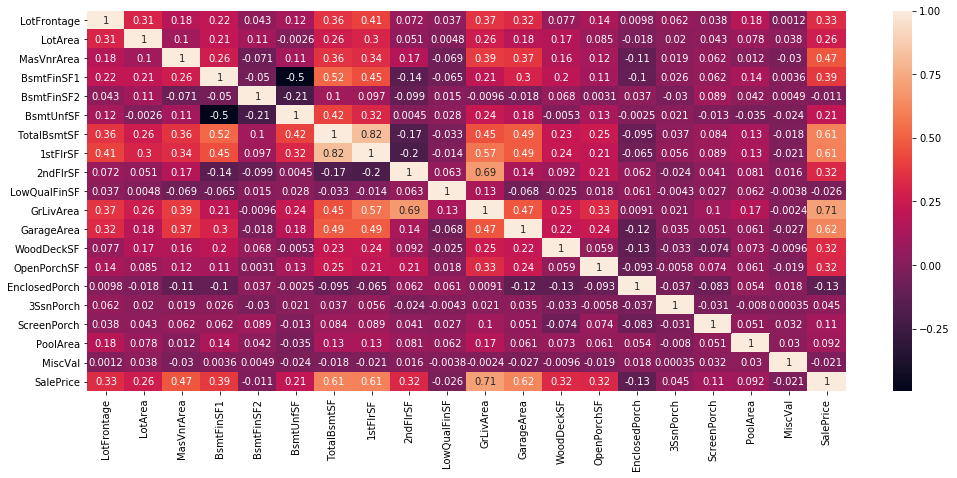

In [99]:
house_price_num_v = house_price_num_v_c.copy()
corr_ = house_prices_df[house_price_num_v].corr()
fig, ax = plt.subplots()
fig.set_size_inches(17,7)
g=sn.heatmap(corr_, annot=True)
plt.setp(g.get_yticklabels(), rotation=0)
plt.show()

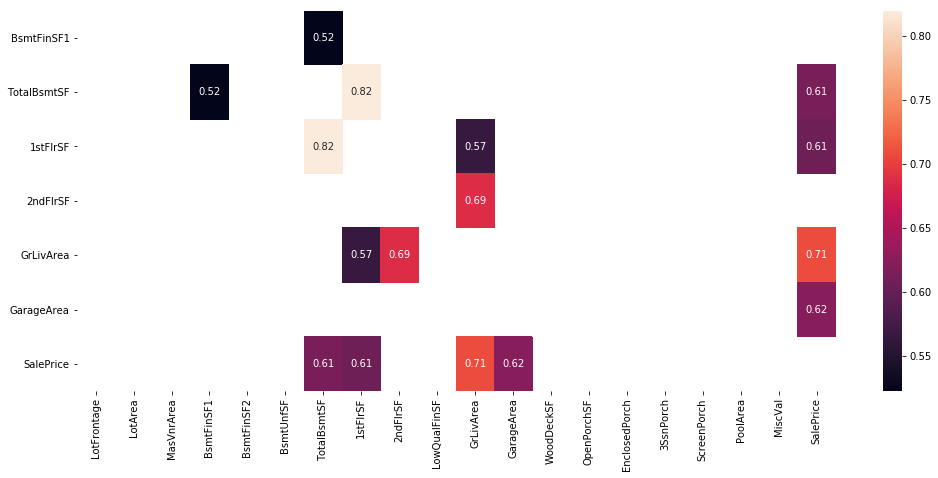

In [100]:
corr_ = house_prices_df[house_price_num_v].corr()
fig, ax = plt.subplots()
fig.set_size_inches(17,7)
g=sn.heatmap(corr_.loc[((np.abs(corr_)>0.5) & (np.abs(corr_)<1)).sum()>0][
    (np.abs(corr_)>0.5) & (np.abs(corr_)<1)] , annot=True)
plt.setp(g.get_yticklabels(), rotation=0)
plt.show()

In [101]:
house_price_num_v.remove("BsmtUnfSF")
house_price_num_v.remove("BsmtFinSF1")
house_price_num_v.remove("1stFlrSF")
house_price_num_v.remove("2ndFlrSF")

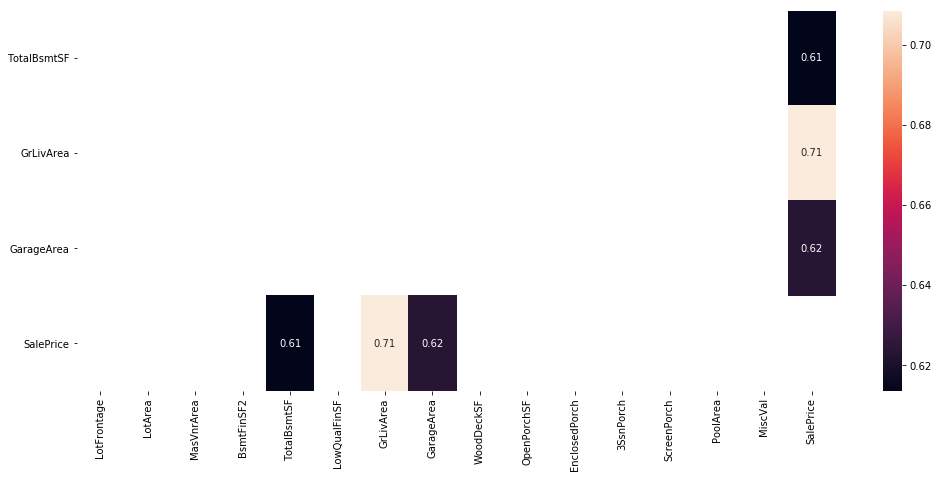

In [102]:
corr_ = house_prices_df[house_price_num_v].corr()
fig, ax = plt.subplots()
fig.set_size_inches(17,7)
g=sn.heatmap(corr_.loc[((np.abs(corr_)>0.5) & (np.abs(corr_)<1)).sum()>0][
    (np.abs(corr_)>0.5) & (np.abs(corr_)<1)] , annot=True)
plt.setp(g.get_yticklabels(), rotation=0)
plt.show()

In [103]:
house_price_desc_df

Id   MSSubClass MSZoning  LotFrontage        LotArea Street  \
count   1460.000000  1460.000000     1460  1460.000000    1460.000000   1460   
unique          NaN          NaN        5          NaN            NaN      2   
top             NaN          NaN       RL          NaN            NaN   Pave   
freq            NaN          NaN     1151          NaN            NaN   1454   
mean     730.500000    56.897260      NaN    70.049958   10516.828082    NaN   
std      421.610009    42.300571      NaN    22.024023    9981.264932    NaN   
min        1.000000    20.000000      NaN    21.000000    1300.000000    NaN   
25%      365.750000    20.000000      NaN    60.000000    7553.500000    NaN   
50%      730.500000    50.000000      NaN    70.049958    9478.500000    NaN   
75%     1095.250000    70.000000      NaN    79.000000   11601.500000    NaN   
max     1460.000000   190.000000      NaN   313.000000  215245.000000    NaN   

           Alley LotShape LandContour Utilities LotConfig LandSlope  \
count       1460     1460        1460      1460      1460      1460   
unique         3        4           4         2         5         3   
top     No Alley      Reg         Lvl    AllPub    Inside       Gtl   
freq        1369      925        1311      1459      1052      1382   
mean         NaN      NaN         NaN       NaN       NaN       NaN   
std          NaN      NaN         NaN       NaN       NaN       NaN   
min          NaN      NaN         NaN       NaN       NaN       NaN   
25%          NaN      NaN         NaN       NaN       NaN       NaN   
50%          NaN      NaN         NaN       NaN       NaN       NaN   
75%          NaN      NaN         NaN       NaN       NaN       NaN   
max          NaN      NaN         NaN       NaN       NaN       NaN   

       Neighborhood Condition1 Condition2 BldgType HouseStyle  OverallQual  \
count          1460       1460       1460     1460       1460  1460.000000   
unique           25          9          8        5          8          NaN   
top           NAmes       Norm       Norm     1Fam     1Story          NaN   
freq            225       1260       1445     1220        726          NaN   
mean            NaN        NaN        NaN      NaN        NaN     6.099315   
std             NaN        NaN        NaN      NaN        NaN     1.382997   
min             NaN        NaN        NaN      NaN        NaN     1.000000   
25%             NaN        NaN        NaN      NaN        NaN     5.000000   
50%             NaN        NaN        NaN      NaN        NaN     6.000000   
75%             NaN        NaN        NaN      NaN        NaN     7.000000   
max             NaN        NaN        NaN      NaN        NaN    10.000000   

        OverallCond    YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st  \
count   1460.000000  1460.000000   1460.000000      1460     1460        1460   
unique          NaN          NaN           NaN         6        8          15   
top             NaN          NaN           NaN     Gable  CompShg     VinylSd   
freq            NaN          NaN           NaN      1141     1434         515   
mean       5.575342  1971.267808   1984.865753       NaN      NaN         NaN   
std        1.112799    30.202904     20.645407       NaN      NaN         NaN   
min        1.000000  1872.000000   1950.000000       NaN      NaN         NaN   
25%        5.000000  1954.000000   1967.000000       NaN      NaN         NaN   
50%        5.000000  1973.000000   1994.000000       NaN      NaN         NaN   
75%        6.000000  2000.000000   2004.000000       NaN      NaN         NaN   
max        9.000000  2010.000000   2010.000000       NaN      NaN         NaN   

       Exterior2nd MasVnrType   MasVnrArea ExterQual ExterCond Foundation  \
count         1460       1460  1460.000000      1460      1460       1460   
unique          16          5          NaN         4         5          6   
top        VinylSd       None          NaN        TA        TA

Normalizing all input variables using Z-Score

In [104]:
house_price_num_zv = []
for column in house_price_num_v:
    house_price_num_zv.append(column+"_zscore")
    house_prices_df[column+"_zscore"] = (house_prices_df[column]-
                                         house_price_desc_df.loc["mean",column])/house_price_desc_df.loc["std",column]

In [105]:
house_prices_df[house_price_num_zv].head()

LotFrontage_zscore  LotArea_zscore  MasVnrArea_zscore  BsmtFinSF2_zscore  \
0           -0.229293       -0.207071           0.513949          -0.288554   
1            0.451781       -0.091855          -0.570514          -0.288554   
2           -0.093078        0.073455           0.325828          -0.288554   
3           -0.456318       -0.096864          -0.570514          -0.288554   
4            0.633401        0.375020           1.366028          -0.288554   

   TotalBsmtSF_zscore  LowQualFinSF_zscore  GrLivArea_zscore  \
0           -0.459145            -0.120201          0.370207   
1            0.466305            -0.120201         -0.482347   
2           -0.313261            -0.120201          0.514836   
3           -0.687089            -0.120201          0.383528   
4            0.199611            -0.120201          1.298881   

   GarageArea_zscore  WoodDeckSF_zscore  OpenPorchSF_zscore  \
0           0.350880          -0.751918            0.216429   
1          -0.060710           1.625638           -0.704242   
2           0.631510          -0.751918           -0.070337   
3           0.790533          -0.751918           -0.175988   
4           1.697903           0.779930            0.563567   

   EnclosedPorch_zscore  3SsnPorch_zscore  ScreenPorch_zscore  \
0             -0.359202         -0.116299           -0.270116   
1             -0.359202         -0.116299           -0.270116   
2             -0.359202         -0.116299           -0.270116   
3              4.091122         -0.116299           -0.270116   
4             -0.359202         -0.116299           -0.270116   

   PoolArea_zscore  MiscVal_zscore  SalePrice_zscore  
0        -0.068668       -0.087658          0.347154  
1        -0.068668       -0.087658          0.007286  
2        -0.068668       -0.087658          0.535970  
3        -0.068668       -0.087658         -0.515105  
4        -0.068668       -0.087658          0.869545

In [106]:
# house_prices_df[house_price_num_v].head()

In [107]:
print("Numerical columns ", len(house_price_num_v))
print("Numerical Z Score columns ", len(house_price_num_zv))
print("\n")
print("Categorical columns ", len(house_price_cat_v))
print("Label Encoded Categorical columns ", len(house_price_cat_fv))
print("\n")
print("Ordinal columns ", len(house_price_ord_v))

Numerical columns  16
Numerical Z Score columns  16


Categorical columns  31
Label Encoded Categorical columns  224


Ordinal columns  26


In [108]:
# house_price_num_zv = house_price_num_v
# house_price_num_zv.extend(house_price_cat_fv)
house_price_num_zv.extend(house_price_cat_v)
house_price_num_zv.extend(house_price_ord_v)

In [109]:
len(house_price_num_zv) 

73

In [110]:
house_price_num_zv.remove("SalePrice_zscore")

In [111]:
house_prices_df[house_price_num_zv].head()

LotFrontage_zscore  LotArea_zscore  MasVnrArea_zscore  BsmtFinSF2_zscore  \
0           -0.229293       -0.207071           0.513949          -0.288554   
1            0.451781       -0.091855          -0.570514          -0.288554   
2           -0.093078        0.073455           0.325828          -0.288554   
3           -0.456318       -0.096864          -0.570514          -0.288554   
4            0.633401        0.375020           1.366028          -0.288554   

   TotalBsmtSF_zscore  LowQualFinSF_zscore  GrLivArea_zscore  \
0           -0.459145            -0.120201          0.370207   
1            0.466305            -0.120201         -0.482347   
2           -0.313261            -0.120201          0.514836   
3           -0.687089            -0.120201          0.383528   
4            0.199611            -0.120201          1.298881   

   GarageArea_zscore  WoodDeckSF_zscore  OpenPorchSF_zscore  \
0           0.350880          -0.751918            0.216429   
1          -0.060710           1.625638           -0.704242   
2           0.631510          -0.751918           -0.070337   
3           0.790533          -0.751918           -0.175988   
4           1.697903           0.779930            0.563567   

   EnclosedPorch_zscore  3SsnPorch_zscore  ScreenPorch_zscore  \
0             -0.359202         -0.116299           -0.270116   
1             -0.359202         -0.116299           -0.270116   
2             -0.359202         -0.116299           -0.270116   
3              4.091122         -0.116299           -0.270116   
4             -0.359202         -0.116299           -0.270116   

   PoolArea_zscore  MiscVal_zscore  MSSubClass  MSZoning  Street  Alley  \
0        -0.068668       -0.087658           5         3       1      1   
1        -0.068668       -0.087658           0         3       1      1   
2        -0.068668       -0.087658           5         3       1      1   
3        -0.068668       -0.087658           6         3       1      1   
4        -0.068668       -0.087658           5         3       1      1   

   LandContour  LotConfig  Neighborhood  Condition1  Condition2  BldgType  \
0            3          4             5           2           2         0   
1            3          2            24           1           2         0   
2            3          4             5           2           2         0   
3            3          0             6           2           2         0   
4            3          2            15           2           2         0   

   HouseStyle  RoofStyle  RoofMatl  Exterior1st  Exterior2nd  MasVnrType  \
0           5          1         1           12           13           1   
1           2          1         1            8            8           3   
2           5          1         1           12           13           1   
3           5          1         1           13           15           3   
4           5          1         1           12           13           1   

   Foundation  Heating  CentralAir  BsmtFullBath  BsmtHalfBath  FullBath  \
0           2        1           1             1             0         2   
1           1        1           1             0             1         2   
2           2        1           1             1             0         2   
3           0        1           1             1             0         1   
4           2        1           1             1             0         2   

   HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageType  \
0         1             3             1             6           0           1   
1         0             3             1             4           1           1   
2         1             3             1             4           1           1   
3         0             3             1             5           1           5   
4         1             4             1             7           1           1   

   GarageCars  MiscFeature  MoSold LotShape Utilities Land

#### Target variable normal distribution

Text(0.5,1,'log (SalePrice)')

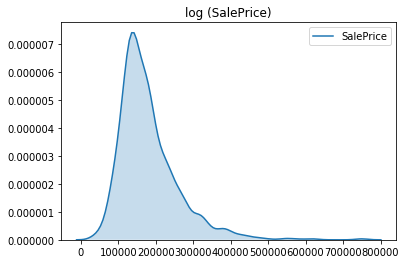

In [112]:
sn.kdeplot(house_prices_df["SalePrice"], shade=True).set_title(" (SalePrice)")

Text(0.5,1,'log (SalePrice)')

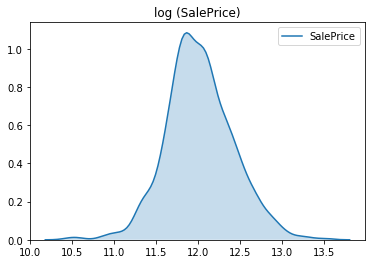

In [113]:
sn.kdeplot(np.log(house_prices_df["SalePrice"]), shade=True).set_title("log (SalePrice)")

As log transforming the target variable converts data into nearly normal distribution, we use log(SalesPrice) in predictive models.

#### Relation of every categorical variable with target variable

In [114]:
len(house_price_cat_v)

31

##  Creating Copy

In [115]:
house_prices_df_master = house_prices_df.copy()

## Test Train Split
Split data for SalePrice < 500000 as values above 500000 are outliers and a very few(9 records) are present

In [116]:
house_prices_df = house_prices_df_master.loc[(house_prices_df_master["SalePrice"]<500000) ].copy()
# house_prices_df = house_prices_df_master.copy()
X_train,X_test,y_train,y_test = fn_train_test_split(house_prices_df)

 X Shape :  (1451, 321)
 X Train Shape :  (1088, 321)
 X Test Shape :  (363, 321)
 Y Shape :  (1451,)
 Y Train Shape :  (1088,)
 Y Test Shape :  (363,)


In [117]:
X_train.head()

Id  MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  \
177    178           4         3    70.049958    13650       1      1   
311    312           0         3    50.000000     8000       1      1   
31      32           0         3    70.049958     8544       1      1   
1097  1098          11         3    70.049958     3696       1      1   
1420  1421           5         3    90.000000    11700       1      1   

     LotShape  LandContour Utilities  LotConfig LandSlope  Neighborhood  \
177         4            3         4          4         3            19   
311         4            3         4          4         3            12   
31          3            3         4          1         3            19   
1097        4            3         4          4         3            22   
1420        4            3         4          0         3            14   

      Condition1  Condition2  BldgType  HouseStyle OverallQual OverallCond  \
177            2           2         0           0           5           5   
311            2           2         0           2           6           6   
31             2           2         0           2           5           6   
1097           2           2         4           2           8           5   
1420           2           2         0           5           6           6   

     YearBuilt YearRemodAdd  RoofStyle  RoofMatl  Exterior1st  Exterior2nd  \
177       1958         1958          1         1            8            8   
311       1948         2002          1         1           12           13   
31        1966         2006          1         1            6            6   
1097      1986         1986          1         1            6            6   
1420      1968         1968          1         1            6            6   

      MasVnrType  MasVnrArea ExterQual ExterCond  Foundation BsmtQual  \
177            3         0.0         4         4           1        3   
311            3         0.0         3         4           1        3   
31             3         0.0         3         3           1        3   
1097           3         0.0         4         3           1        4   
1420           1       420.0         3         3           1        3   

     BsmtCond BsmtExposure BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  \
177         3            1            5          57            4         441   
311         3            1            5         680            1           0   
31          3            1            1           0            1           0   
1097        3            1            1           0            1           0   
1420        3            1            5         404            1           0   

      BsmtUnfSF  TotalBsmtSF  Heating HeatingQC  CentralAir Electrical  \
177         554         1052        1         5           1          5   
311         292          972        1         5           1          5   
31         1228         1228        1         4           1          5   
1097       1074         1074        1         5           1          5   
1420        304          708        1         4           1          5   

      1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
177       1252       668             0       1920             1             0   
311        972         0             0        972             1             0   
31        1228         0             0       1228             0             0   
1097      1088         0             0       1088             0             0   
1420       708       708             0       1416             0             0   

      FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr KitchenQual  \
177          2         0             4             1           4   
311          1         0             2             1           3   
31           1         1             3             1           4   
1097         1         1             2             1    

## Predictive Modelling

## Model 1

### Linear Regression

In [118]:
regr = linear_model.LinearRegression()
regr.fit(X_train[house_price_num_zv], y_train)
y_train_pred = regr.predict(X_train[house_price_num_zv])
y_pred = regr.predict(X_test[house_price_num_zv])
regr.score(X_train[house_price_num_zv], y_train)

0.8751004461750618

In [119]:
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [-5.85696439e-03  2.09384665e-02  5.34651418e-03  1.26675447e-02
  1.16285087e-02  5.96672284e-03  8.37465976e-02  1.62105525e-02
  1.44537108e-02  3.91668701e-03  1.03733777e-02  6.39200140e-03
  1.61706406e-02  1.78407697e-02  2.67133345e-02 -3.87775850e-03
 -3.46820868e-03  1.80815181e-01  2.50734856e-02  1.57003322e-02
 -3.12665035e-03  1.24619219e-03  5.48270833e-03 -5.91513942e-02
 -1.09735916e-02 -7.05328682e-03  2.19956726e-03  3.84314575e-03
 -6.03113709e-03  6.22288620e-03  2.72575989e-03  2.16801100e-02
  1.29493231e-02  4.18603408e-02  4.93907775e-02  3.47546897e-02
  3.72043497e-02  1.96122306e-02  1.22271205e-02  1.22612558e-02
  9.44831022e-03 -1.51393858e-04 -7.76482225e-03  5.30311051e-02
 -2.74766688e-02  1.06985863e-03  2.40227257e-03  1.34041879e-01
 -2.43282437e-02  6.16956750e-02  3.94555131e-02  2.11089260e-02
 -1.60536345e-02  2.92178558e-02 -5.79803765e-04  1.65211386e-02
  8.92260089e-03 -1.23848281e-02  1.60188299e-02  3.59240963e-03
  1.69531

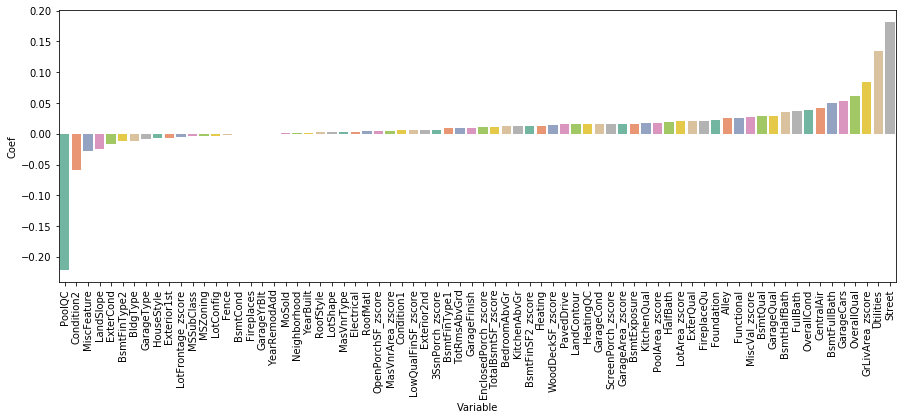

In [120]:
coeff = pd.DataFrame({"Coef":regr.coef_, "Variable":house_price_num_zv})
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
g = sn.barplot(y="Coef", x="Variable", data = coeff.sort_values(by="Coef"), palette="Set2")
plt.setp( g.get_xticklabels(), rotation=90)
plt.show()

In [121]:
metrics_ = get_regression_metrics(y_test,y_pred)

Mean squared error: 0.02
Root Mean squared error: 0.15
Explained Variance: 0.87
R2 Score: 0.87
Mean Absolute error: 0.10
Mean Squared Log error: 0.00
Median Absolute error: 0.07


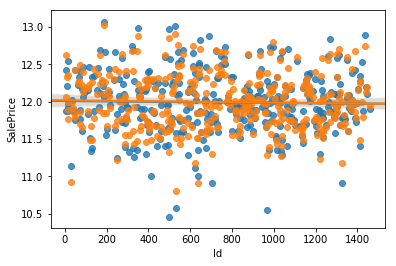

In [122]:
fig, ax = plt.subplots()
sn.regplot(X_test["Id"], y_test)
sn.regplot(X_test["Id"], y_pred)

In [123]:
train_error_df = get_metric_df(X_train["SalePrice"],y_train, y_train_pred)

In [124]:
train_error_df.head()

ActualLogValue  ActualValue  ExpActualgLog  PredcitedValue  \
177        12.058153       172500       172500.0   182471.632874   
311        11.790557       132000       132000.0   137365.294315   
31         11.914048       149350       149350.0   128814.058982   
1097       12.043554       170000       170000.0   156303.052651   
1420       12.100156       179900       179900.0   175526.107020   

      PredictedLogValue         Error  Error_per  Error_per_cls  
177           12.114350  -9971.632874   5.780657              1  
311           11.830399  -5365.294315   4.064617              1  
31            11.766125  20535.941018  13.750212              1  
1097          11.959552  13696.947349   8.057028              1  
1420          12.075543   4373.892980   2.431291              1

In [125]:
test_error_df = get_metric_df(X_test["SalePrice"],y_test,y_pred)

In [126]:
test_error_df.head()

ActualLogValue  ActualValue  ExpActualgLog  PredcitedValue  \
539        12.513557       272000       272000.0   263312.644495   
320        12.744444       342643       342643.0   319952.243066   
164        11.931636       152000       152000.0   145284.528022   
1249       11.686879       119000       119000.0   116297.914932   
985        11.736069       125000       125000.0   104767.223279   

      PredictedLogValue         Error  Error_per  Error_per_cls  
539           12.481097   8687.355505   3.193881              1  
320           12.675927  22690.756934   6.622274              1  
164           11.886449   6715.471978   4.418074              1  
1249          11.663910   2702.085068   2.270660              1  
985           11.559496  20232.776721  16.186221              1

## Metrics

### Training Dataset

#### Metrics in Train Dataset

In [127]:
train_err_met = get_regression_metrics(train_error_df["ActualValue"], train_error_df["PredcitedValue"])

Mean squared error: 765796697.57
Root Mean squared error: 27673.03
Explained Variance: 0.85
R2 Score: 0.85
Mean Absolute error: 16344.06
Mean Squared Log error: 0.02
Median Absolute error: 11048.32


#### Plot of Actual Value and Predicted Value
Actual Value - Blue
Pred value - Orange

In [128]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sn.regplot(X_train["Id"], y_train)
sn.regplot(X_train["Id"], y_train_pred)

In most of the data points, the orange and blue dots overlap

#### Plot between actual and predicted values.

In [129]:
fig, ax = plt.subplots()
sn.regplot(train_error_df["ActualValue"], train_error_df["PredcitedValue"])

Most of the data points in training datset lie around the predictive line, although, few value are predicted too high. 

#### PLot beween Actual and Pred values colored by percentage error. 
 0,  16.66,  33.3,  50, 66.66,  83.33, 100

In [130]:
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False, data=train_error_df)
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False,  data=train_error_df.loc[
    train_error_df["Error_per_cls"]!=1])

#### Error Distributions

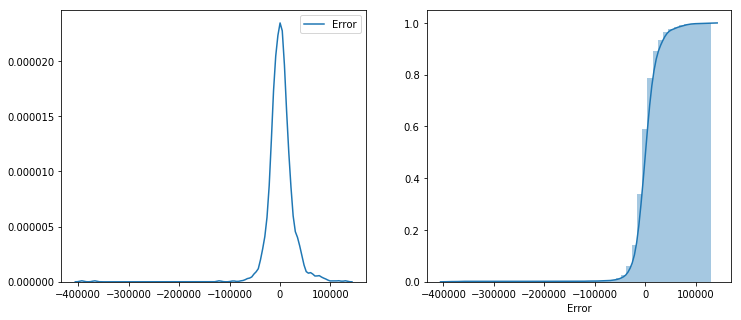

In [131]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.kdeplot(train_error_df["Error"],ax=ax[0])
sn.distplot(train_error_df["Error"],
            hist_kws=dict(cumulative=True),
            kde_kws=dict(cumulative=True), ax=ax[1])

Most of the errors are centered at 0

### Test Dataset

Metrics in Test Dataset

In [132]:
test_err_met = get_regression_metrics(test_error_df["ActualValue"], test_error_df["PredcitedValue"])

Mean squared error: 662495042.43
Root Mean squared error: 25738.98
Explained Variance: 0.87
R2 Score: 0.87
Mean Absolute error: 17062.09
Mean Squared Log error: 0.02
Median Absolute error: 11661.89


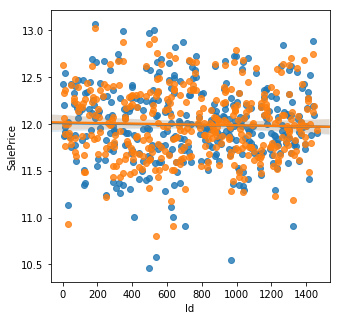

In [133]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sn.regplot(X_test["Id"], y_test)
sn.regplot(X_test["Id"], y_pred)

In [134]:
sn.regplot(test_error_df["ActualValue"], test_error_df["PredcitedValue"], fit_reg=False)

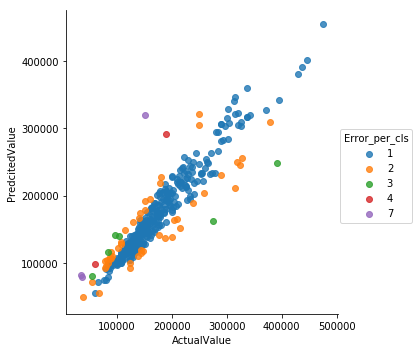

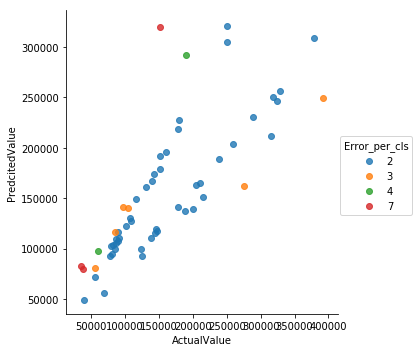

In [135]:
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False, data=test_error_df)
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False,  data=test_error_df.loc[
    test_error_df["Error_per_cls"]!=1])

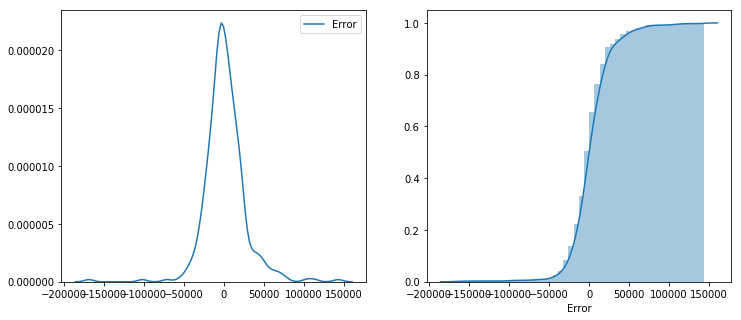

In [136]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.kdeplot(test_error_df["Error"],ax=ax[0])
sn.distplot(test_error_df["Error"],
            hist_kws=dict(cumulative=True),
            kde_kws=dict(cumulative=True), ax=ax[1])

In [137]:
set_all_error_metrics("Linear_Regression",train_err_met,test_err_met,regr)

## Model 2

### Lasso Regression

In [180]:
# regr = linear_model.Lasso(alpha=0.00018, normalize=True) - 87 81 90
regr = linear_model.Lasso(alpha=0.0041) # 88 87 86
# regr = linear_model.Lasso(alpha=0.00088)- 87 84 89
regr.fit(X_train[house_price_num_zv], y_train)
y_train_pred = regr.predict(X_train[house_price_num_zv])
y_pred = regr.predict(X_test[house_price_num_zv])
regr.score(X_train[house_price_num_zv], y_train)

0.8611348534042628

In [181]:
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [-0.00000000e+00  1.85584583e-02  0.00000000e+00  2.54538623e-03
  3.71745618e-03  0.00000000e+00  9.82593778e-02  1.55188865e-02
  1.23869332e-02  6.53900947e-05  6.57502298e-04  6.03282510e-04
  1.32301826e-02 -1.71254331e-02  0.00000000e+00 -4.76964115e-03
 -0.00000000e+00  0.00000000e+00  0.00000000e+00  6.44599114e-03
 -1.04369605e-03  1.56097979e-03  0.00000000e+00 -0.00000000e+00
 -5.60374923e-03 -5.78812216e-03  0.00000000e+00  0.00000000e+00
 -3.30430714e-03  3.19668852e-03 -0.00000000e+00  3.51683095e-03
  0.00000000e+00  0.00000000e+00  2.13280590e-02  0.00000000e+00
  8.93524094e-03  0.00000000e+00  2.14533337e-03  0.00000000e+00
  1.49921423e-02  0.00000000e+00 -8.77503352e-03  4.18218630e-02
 -0.00000000e+00  6.63630221e-04 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00  6.87951890e-02  3.46533563e-02  2.96471581e-03
 -0.00000000e+00  1.79095795e-02  0.00000000e+00  1.64829982e-02
  1.33439328e-02  0.00000000e+00  1.43295263e-02  0.00000000e+00
  8.70273

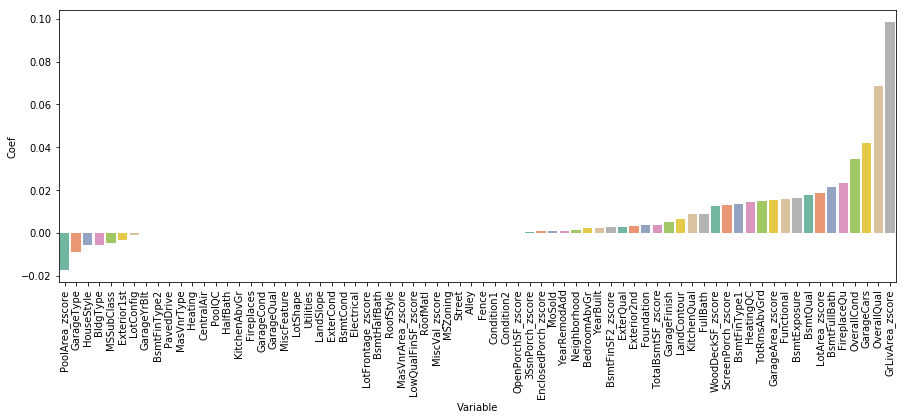

In [182]:
coeff = pd.DataFrame({"Coef":regr.coef_, "Variable":house_price_num_zv})
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
g = sn.barplot(y="Coef", x="Variable", data = coeff.sort_values(by="Coef"), palette="Set2")
plt.setp( g.get_xticklabels(), rotation=90)
plt.show()

In [183]:
metrics = get_regression_metrics(y_test,y_pred)

Mean squared error: 0.02
Root Mean squared error: 0.14
Explained Variance: 0.88
R2 Score: 0.88
Mean Absolute error: 0.10
Mean Squared Log error: 0.00
Median Absolute error: 0.07


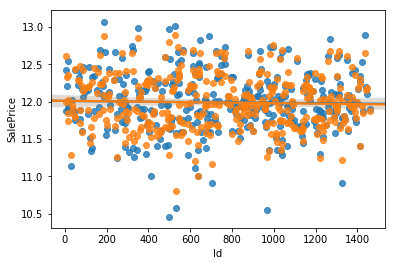

In [184]:
fig, ax = plt.subplots()
sn.regplot(X_test["Id"], y_test)
sn.regplot(X_test["Id"], y_pred)

In [185]:
train_error_df = get_metric_df(X_train["SalePrice"],y_train, y_train_pred)

In [186]:
train_error_df.head()

ActualLogValue  ActualValue  ExpActualgLog  PredcitedValue  \
177        12.058153       172500       172500.0   180340.574013   
311        11.790557       132000       132000.0   142390.629342   
31         11.914048       149350       149350.0   131625.268124   
1097       12.043554       170000       170000.0   156268.951063   
1420       12.100156       179900       179900.0   173189.084340   

      PredictedLogValue         Error  Error_per  Error_per_cls  
177           12.102602  -7840.574013   4.545260              1  
311           11.866329 -10390.629342   7.871689              1  
31            11.787714  17724.731876  11.867916              1  
1097          11.959334  13731.048937   8.077088              1  
1420          12.062139   6710.915660   3.730359              1

In [187]:
test_error_df = get_metric_df(X_test["SalePrice"],y_test,y_pred)

In [188]:
test_error_df.head()

ActualLogValue  ActualValue  ExpActualgLog  PredcitedValue  \
539        12.513557       272000       272000.0   248637.461962   
320        12.744444       342643       342643.0   313811.690347   
164        11.931636       152000       152000.0   138165.380184   
1249       11.686879       119000       119000.0   118664.264918   
985        11.736069       125000       125000.0   104732.768215   

      PredictedLogValue         Error  Error_per  Error_per_cls  
539           12.423751  23362.538038   8.589168              1  
320           12.656548  28831.309653   8.414387              1  
164           11.836207  13834.619816   9.101724              1  
1249          11.684053    335.735082   0.282130              1  
985           11.559167  20267.231785  16.213785              1

## Metrics

### Training Dataset

#### Metrics in Train Dataset

In [189]:
train_err_met = get_regression_metrics(train_error_df["ActualValue"], train_error_df["PredcitedValue"])

Mean squared error: 1006957634.24
Root Mean squared error: 31732.60
Explained Variance: 0.80
R2 Score: 0.80
Mean Absolute error: 17257.40
Mean Squared Log error: 0.02
Median Absolute error: 11700.31


#### Plot of Actual Value and Predicted Value
Actual Value - Blue
Pred value - Orange

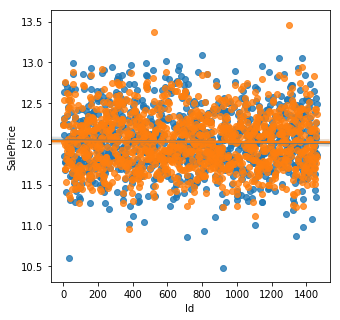

In [190]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sn.regplot(X_train["Id"], y_train)
sn.regplot(X_train["Id"], y_train_pred)

In most of the data points, the orange and blue dots overlap

#### Plot between actual and predicted values.

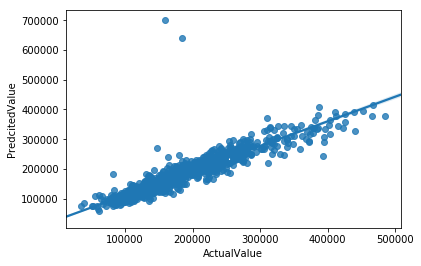

In [191]:
fig, ax = plt.subplots()
sn.regplot(train_error_df["ActualValue"], train_error_df["PredcitedValue"])

Most of the data points in training datset lie around the predictive line, although, few value are predicted too high. 

#### PLot beween Actual and Pred values colored by percentage error. 
 0,  16.66,  33.3,  50, 66.66,  83.33, 100

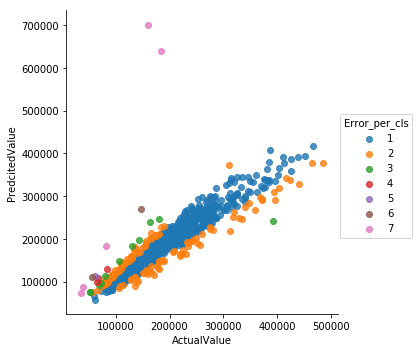

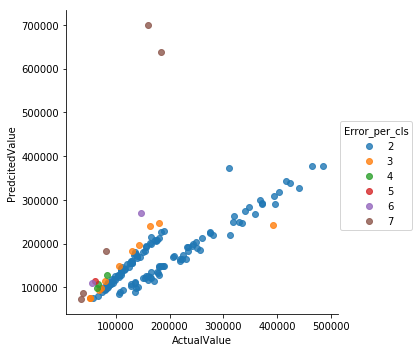

In [192]:
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False, data=train_error_df)
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False,  data=train_error_df.loc[
    train_error_df["Error_per_cls"]!=1])

#### Error Distributions

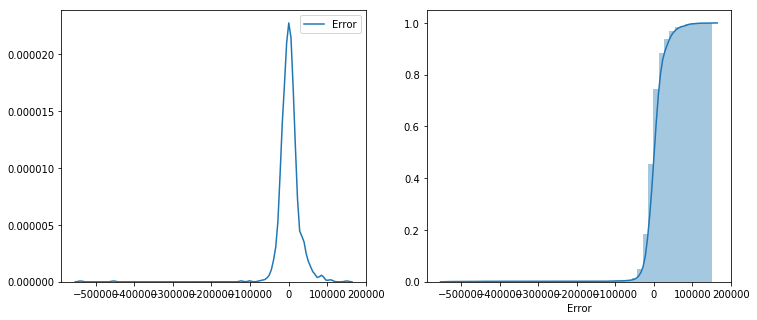

In [193]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.kdeplot(train_error_df["Error"],ax=ax[0])
sn.distplot(train_error_df["Error"],
            hist_kws=dict(cumulative=True),
            kde_kws=dict(cumulative=True), ax=ax[1])

Most of the errors are centered at 0

### Test Dataset

Metrics in Test Dataset

In [194]:
test_err_met = get_regression_metrics(test_error_df["ActualValue"], test_error_df["PredcitedValue"])

Mean squared error: 597231557.41
Root Mean squared error: 24438.32
Explained Variance: 0.89
R2 Score: 0.89
Mean Absolute error: 16717.96
Mean Squared Log error: 0.02
Median Absolute error: 11976.80


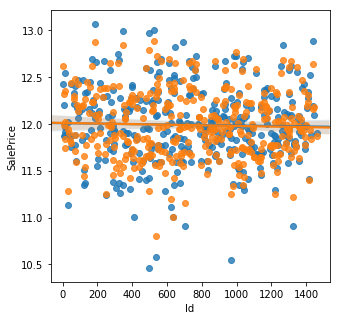

In [195]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sn.regplot(X_test["Id"], y_test)
sn.regplot(X_test["Id"], y_pred)

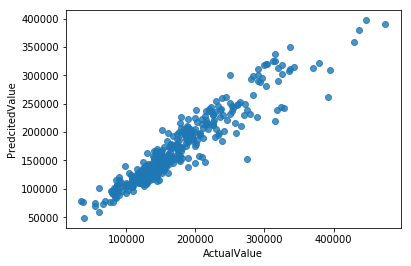

In [196]:
sn.regplot(test_error_df["ActualValue"], test_error_df["PredcitedValue"], fit_reg=False)

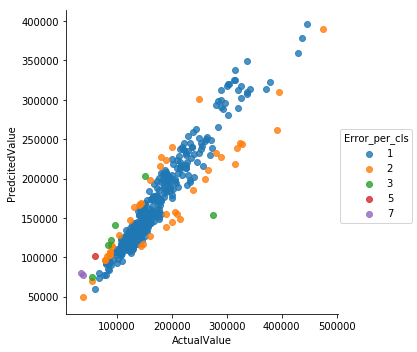

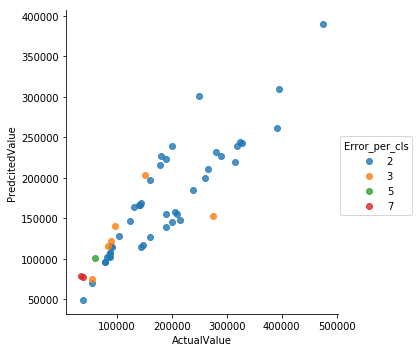

In [197]:
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False, data=test_error_df)
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False,  data=test_error_df.loc[
    test_error_df["Error_per_cls"]!=1])

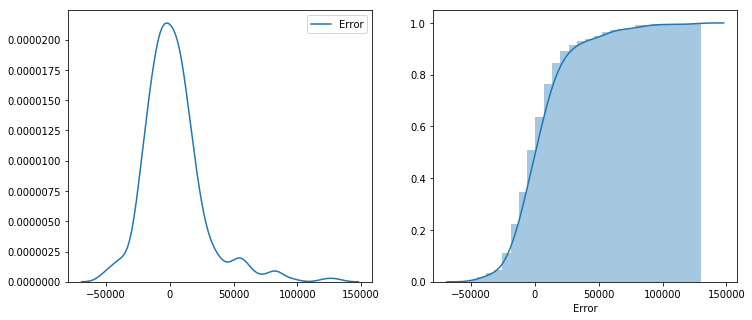

In [198]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.kdeplot(test_error_df["Error"],ax=ax[0])
sn.distplot(test_error_df["Error"],
            hist_kws=dict(cumulative=True),
            kde_kws=dict(cumulative=True), ax=ax[1])

In [199]:
set_all_error_metrics("Lasso_Regression",train_err_met,test_err_met,regr)

## Model 3

### Ridge Regression

In [200]:
regr = linear_model.Ridge(alpha=260)
regr.fit(X_train[house_price_num_zv], y_train)
y_train_pred = regr.predict(X_train[house_price_num_zv])
y_pred = regr.predict(X_test[house_price_num_zv])
regr.score(X_train[house_price_num_zv], y_train)

0.8631213013183383

In [201]:
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [-4.24671477e-03  1.83864609e-02  8.15139003e-03  7.72906251e-03
  1.56878002e-02  3.88828226e-03  4.91403153e-02  2.42410542e-02
  1.46682104e-02  7.05589620e-03  6.90629443e-03  4.49189900e-03
  1.43600989e-02 -1.42413097e-02  8.57485243e-04 -1.92361296e-03
 -2.29060689e-03  3.75641119e-03  5.95251643e-03  8.06250004e-03
 -2.91013594e-03  1.72619409e-03  2.74843650e-03 -6.78028392e-03
 -1.29894847e-02 -7.59897330e-03  3.08986176e-03  8.08386877e-03
 -6.17683090e-03  6.12529259e-03  1.09807095e-03  1.30266781e-02
  2.38820329e-03  7.34792579e-03  1.73209670e-02  1.35201737e-03
  2.03268074e-02  1.32724994e-02  1.17401970e-02  2.65994855e-04
  2.58047718e-02  1.01266174e-02 -9.26367263e-03  2.64610086e-02
 -6.03811131e-03  1.37204697e-03 -1.49963873e-03  2.01824762e-03
 -6.92567726e-03  5.59513161e-02  2.93623686e-02  1.60970301e-02
 -1.39052910e-03  1.80748369e-02  4.98158911e-03  1.63389576e-02
  1.32100793e-02 -4.58799744e-03  1.48859471e-02  7.12651469e-03
  1.63895

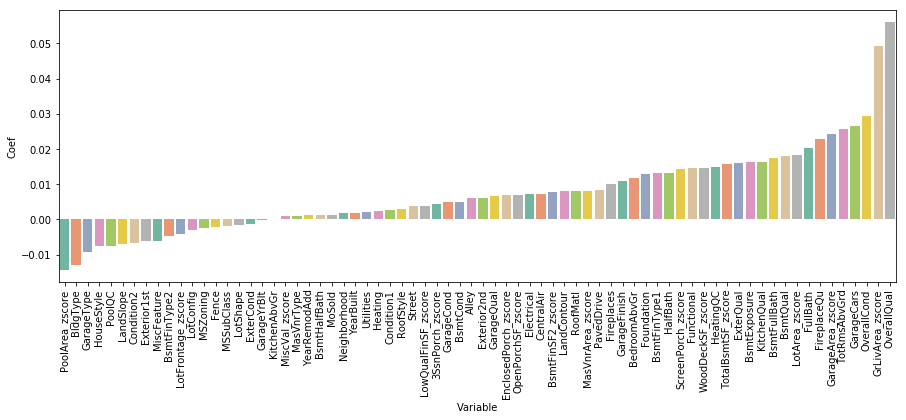

In [202]:
coeff = pd.DataFrame({"Coef":regr.coef_, "Variable":house_price_num_zv})
fig, ax = plt.subplots()
fig.set_size_inches(15,5)
g = sn.barplot(y="Coef", x="Variable", data = coeff.sort_values(by="Coef"), palette="Set2")
plt.setp( g.get_xticklabels(), rotation=90)
plt.show()

In [203]:
metrics = get_regression_metrics(y_test,y_pred)

Mean squared error: 0.02
Root Mean squared error: 0.14
Explained Variance: 0.88
R2 Score: 0.88
Mean Absolute error: 0.10
Mean Squared Log error: 0.00
Median Absolute error: 0.07


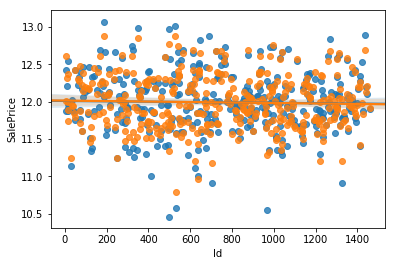

In [204]:
fig, ax = plt.subplots()
sn.regplot(X_test["Id"], y_test)
sn.regplot(X_test["Id"], y_pred)

In [205]:
train_error_df = get_metric_df(X_train["SalePrice"],y_train, y_train_pred)

In [206]:
train_error_df.head()

ActualLogValue  ActualValue  ExpActualgLog  PredcitedValue  \
177        12.058153       172500       172500.0   180222.867442   
311        11.790557       132000       132000.0   141773.096650   
31         11.914048       149350       149350.0   135233.549477   
1097       12.043554       170000       170000.0   155964.339005   
1420       12.100156       179900       179900.0   181139.644808   

      PredictedLogValue         Error  Error_per  Error_per_cls  
177           12.101950  -7722.867442   4.477025              1  
311           11.861983  -9773.096650   7.403861              1  
31            11.814759  14116.450523   9.451925              1  
1097          11.957383  14035.660995   8.256271              1  
1420          12.107024  -1239.644808   0.689074              1

In [207]:
test_error_df = get_metric_df(X_test["SalePrice"],y_test,y_pred)

In [208]:
test_error_df.head()

ActualLogValue  ActualValue  ExpActualgLog  PredcitedValue  \
539        12.513557       272000       272000.0   244245.634200   
320        12.744444       342643       342643.0   300238.837639   
164        11.931636       152000       152000.0   137024.688582   
1249       11.686879       119000       119000.0   118651.468033   
985        11.736069       125000       125000.0   106146.823052   

      PredictedLogValue         Error  Error_per  Error_per_cls  
539           12.405930  27754.365800  10.203811              1  
320           12.612334  42404.162361  12.375610              1  
164           11.827916  14975.311418   9.852179              1  
1249          11.683946    348.531967   0.292884              1  
985           11.572579  18853.176948  15.082542              1

## Metrics

### Training Dataset

#### Metrics in Train Dataset

In [209]:
train_err_met = get_regression_metrics(train_error_df["ActualValue"], train_error_df["PredcitedValue"])

Mean squared error: 912163100.59
Root Mean squared error: 30202.04
Explained Variance: 0.82
R2 Score: 0.82
Mean Absolute error: 17419.34
Mean Squared Log error: 0.02
Median Absolute error: 11685.74


#### Plot of Actual Value and Predicted Value
Actual Value - Blue
Pred value - Orange

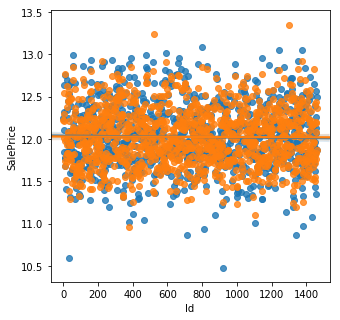

In [210]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sn.regplot(X_train["Id"], y_train)
sn.regplot(X_train["Id"], y_train_pred)

In most of the data points, the orange and blue dots overlap

#### Plot between actual and predicted values.

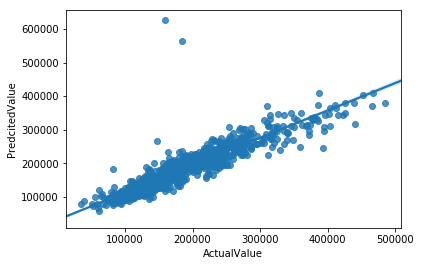

In [211]:
fig, ax = plt.subplots()
sn.regplot(train_error_df["ActualValue"], train_error_df["PredcitedValue"])

Most of the data points in training datset lie around the predictive line, although, few value are predicted too high. 

#### PLot beween Actual and Pred values colored by percentage error. 
 0,  16.66,  33.3,  50, 66.66,  83.33, 100

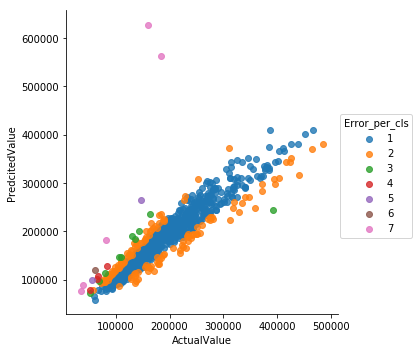

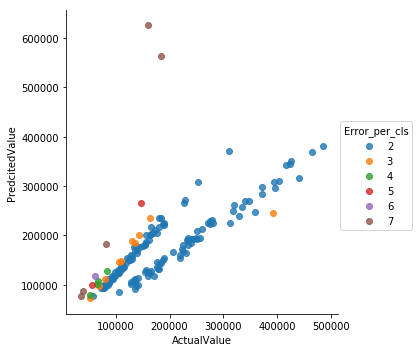

In [212]:
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False, data=train_error_df)
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False,  data=train_error_df.loc[
    train_error_df["Error_per_cls"]!=1])

#### Error Distributions

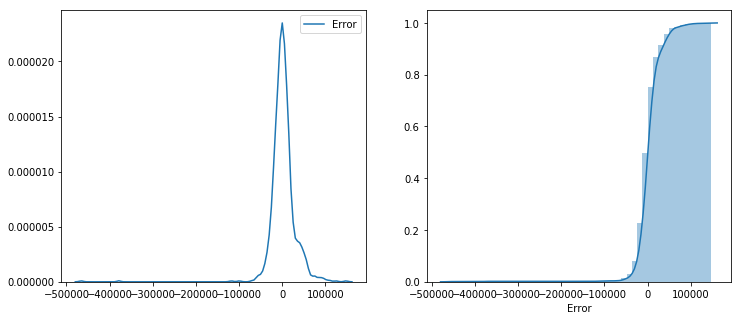

In [213]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.kdeplot(train_error_df["Error"],ax=ax[0])
sn.distplot(train_error_df["Error"],
            hist_kws=dict(cumulative=True),
            kde_kws=dict(cumulative=True), ax=ax[1])

Most of the errors are centered at 0

### Test Dataset

Metrics in Test Dataset

In [214]:
test_err_met = get_regression_metrics(test_error_df["ActualValue"], test_error_df["PredcitedValue"])

Mean squared error: 628269155.54
Root Mean squared error: 25065.30
Explained Variance: 0.88
R2 Score: 0.88
Mean Absolute error: 17145.62
Mean Squared Log error: 0.02
Median Absolute error: 11979.29


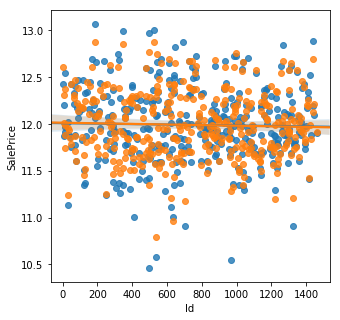

In [215]:
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sn.regplot(X_test["Id"], y_test)
sn.regplot(X_test["Id"], y_pred)

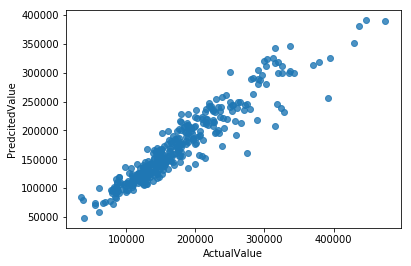

In [216]:
sn.regplot(test_error_df["ActualValue"], test_error_df["PredcitedValue"], fit_reg=False)

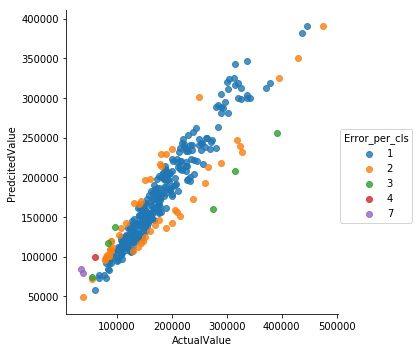

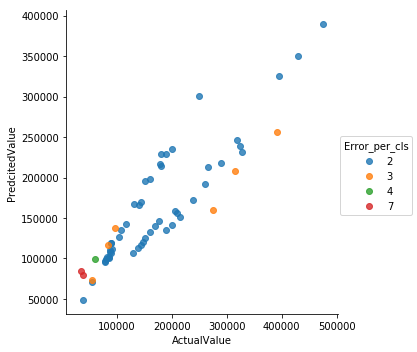

In [217]:
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False, data=test_error_df)
sn.lmplot(x="ActualValue", y="PredcitedValue", hue="Error_per_cls", fit_reg=False,  data=test_error_df.loc[
    test_error_df["Error_per_cls"]!=1])

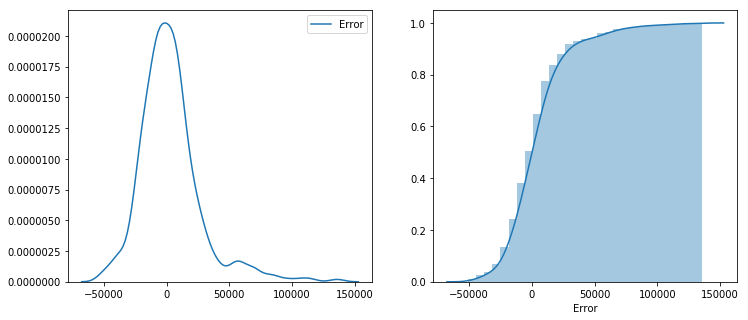

In [218]:
fig, ax = plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.kdeplot(test_error_df["Error"],ax=ax[0])
sn.distplot(test_error_df["Error"],
            hist_kws=dict(cumulative=True),
            kde_kws=dict(cumulative=True), ax=ax[1])

In [219]:
set_all_error_metrics("Ridge_Regression",train_err_met,test_err_met,regr)

## Errors of all Models

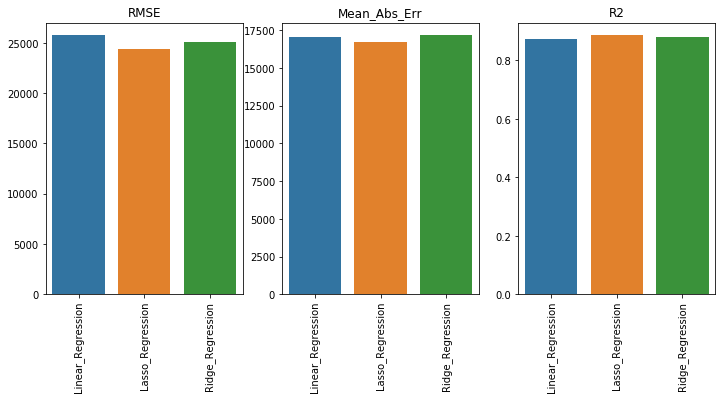

In [220]:
fig, ax = plt.subplots(ncols=3)
fig.set_size_inches(12,5)

x = []
y = []
for model_metric in all_error_metrics_dict_:
    x.append(all_error_metrics_dict_[model_metric]["Test"]["RMSE"])
    y.append(model_metric)
g = sn.barplot(y,x, ax=ax[0])
g.set_title("RMSE")
plt.setp(g.get_xticklabels(), rotation=90)

x = []
y = []
for model_metric in all_error_metrics_dict_:
    x.append(all_error_metrics_dict_[model_metric]["Test"]["Mean_Abs_Err"])
    y.append(model_metric)
g = sn.barplot(y,x, ax=ax[1])
g.set_title("Mean_Abs_Err")
plt.setp(g.get_xticklabels(), rotation=90)


x = []
y = []
for model_metric in all_error_metrics_dict_:
    x.append(all_error_metrics_dict_[model_metric]["Test"]["R2"])
    y.append(model_metric)
g = sn.barplot(y,x, ax=ax[2])
g.set_title("R2")
plt.setp(g.get_xticklabels(), rotation=90)

plt.show()

## Serializng Objects

In [221]:
# Serializing Label Encoder Object
with open('SerializedObjects/labelEncDict.pkl','wb') as f:
    pickle.dump(house_prices_cat_dict,f)
    
# Serializing One Hot Encoder Object
with open('SerializedObjects/oneHotEncDict.pkl','wb') as f:
    pickle.dump(house_prices_cat_ohe_dict,f)

# Serializing Model
for model_metric in all_error_metrics_dict_:
    file = 'SerializedObjects/'+model_metric+'.pkl'
    with open(file,'wb') as f:
        pickle.dump(house_prices_cat_ohe_dict,f)